<a href="https://colab.research.google.com/github/ryukir11/Tugas-Akhir/blob/main/INDIA_RIL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade yfinance

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from tensorflow.keras.optimizers import Adam
import math
import plotly.express as px
import plotly.figure_factory as ff
import yfinance as yf
import statsmodels.api as sm
from statistics import mode
from scipy.stats import kstest
from scipy.stats import shapiro
from scipy.stats import skew
from scipy.stats import kurtosis
import plotly.graph_objects as go
import scipy
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.dates as mdates
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
data = yf.download('^BSESN', start='2000-01-04', end='2024-04-30')

scaler = MinMaxScaler()
def scaling_data(data):
    features = [features for features in data.columns]
    data[features] = scaler.fit_transform(data[features])
    return data

data = scaling_data(data)
data

[*********************100%***********************]  1 of 1 completed


Price          Close      High       Low      Open    Volume
Ticker        ^BSESN    ^BSESN    ^BSESN    ^BSESN    ^BSESN
Date                                                        
2000-01-04  0.039908  0.039361  0.038519  0.040165  0.000000
2000-01-05  0.038058  0.038400  0.035861  0.036457  0.000000
2000-01-06  0.038949  0.038752  0.038725  0.038651  0.000000
2000-01-07  0.038852  0.038385  0.037884  0.037742  0.000000
2000-01-10  0.040286  0.041215  0.039676  0.041319  0.000000
...              ...       ...       ...       ...       ...
2024-04-23  0.982058  0.985307  0.984501  0.985168  0.000201
2024-04-24  0.983638  0.986159  0.985890  0.983908  0.000207
2024-04-25  0.990354  0.992366  0.982671  0.978595  0.000371
2024-04-26  0.981943  0.991602  0.983508  0.991518  0.000431
2024-04-29  0.994935  0.994435  0.987742  0.984255  0.000311

[5994 rows x 5 columns]

In [ ]:
data2 = yf.download('^BSESN', start='2000-01-04', end='2024-04-30')
mini = data2['Close'].min()
max = data2['Close'].max()
price_range = max-mini
range_value = price_range.iloc[0]
range_value

[*********************100%***********************]  1 of 1 completed


np.float64(72438.0283203125)

In [ ]:
ret_df = data['Close']
def windowed_df(data, n):
    dates = []
    data_as_np = data.to_numpy()
    l = data.shape[0]
    dates = []
    X, Y = [], []
    for i in range(n, l):
        indexes = data.index[i-n:i+1]
        row = [r for r in data_as_np[i-n:i]]
        X.append(row)
        y = data_as_np[i][-1]
        Y.append(y)
        dates.append(indexes[-1])
    return np.array(X), np.array(Y), np.array(dates)

In [ ]:
X, y, dates = windowed_df(ret_df, 5)

In [ ]:
data['Date'] = pd.to_datetime(data.index)

data.set_index('Date', inplace=True)

all_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')

data_full = data.reindex(all_dates)

data_full = data_full.interpolate(method='linear')

data_full = data_full.reset_index()
data_full.rename(columns={'index': 'Date'}, inplace=True)
df = data_full.copy()
print(data_full)

Price        Date     Close      High       Low      Open    Volume
Ticker               ^BSESN    ^BSESN    ^BSESN    ^BSESN    ^BSESN
0      2000-01-04  0.039908  0.039361  0.038519  0.040165  0.000000
1      2000-01-05  0.038058  0.038400  0.035861  0.036457  0.000000
2      2000-01-06  0.038949  0.038752  0.038725  0.038651  0.000000
3      2000-01-07  0.038852  0.038385  0.037884  0.037742  0.000000
4      2000-01-08  0.039330  0.039328  0.038481  0.038934  0.000000
...           ...       ...       ...       ...       ...       ...
8878   2024-04-25  0.990354  0.992366  0.982671  0.978595  0.000371
8879   2024-04-26  0.981943  0.991602  0.983508  0.991518  0.000431
8880   2024-04-27  0.986274  0.992546  0.984920  0.989097  0.000391
8881   2024-04-28  0.990605  0.993491  0.986331  0.986676  0.000351
8882   2024-04-29  0.994935  0.994435  0.987742  0.984255  0.000311

[8883 rows x 6 columns]


In [ ]:
def calculate_forward_trend_duration1(prices):
    n = len(prices)
    durations = [1] * n
    for i in range(n-1):
        count = 0
        j = i + 1

        if prices[j] > prices[i]:
            trend = "up"
        elif prices[j] < prices[i]:
            trend = "down"
        else:
            trend = "none"

        while j < n:
            if trend == "up" and prices[j] > prices[j - 1]:
                count += 1
            elif trend == "down" and prices[j] < prices[j - 1]:
                count += 1
            else:
                break
            j += 1

        durations[i] = count
    return durations

data_full['Trend_Duration'] = calculate_forward_trend_duration1(data_full['Close'].values)
print(data_full)

Price        Date     Close      High       Low      Open    Volume  \
Ticker               ^BSESN    ^BSESN    ^BSESN    ^BSESN    ^BSESN   
0      2000-01-04  0.039908  0.039361  0.038519  0.040165  0.000000   
1      2000-01-05  0.038058  0.038400  0.035861  0.036457  0.000000   
2      2000-01-06  0.038949  0.038752  0.038725  0.038651  0.000000   
3      2000-01-07  0.038852  0.038385  0.037884  0.037742  0.000000   
4      2000-01-08  0.039330  0.039328  0.038481  0.038934  0.000000   
...           ...       ...       ...       ...       ...       ...   
8878   2024-04-25  0.990354  0.992366  0.982671  0.978595  0.000371   
8879   2024-04-26  0.981943  0.991602  0.983508  0.991518  0.000431   
8880   2024-04-27  0.986274  0.992546  0.984920  0.989097  0.000391   
8881   2024-04-28  0.990605  0.993491  0.986331  0.986676  0.000351   
8882   2024-04-29  0.994935  0.994435  0.987742  0.984255  0.000311   

Price  Trend_Duration  
Ticker                 
0                   1  
1   

## LSTM MODEL

In [ ]:
data_full.index = data_full['Date']
data_full

Price            Date     Close      High       Low      Open    Volume  \
Ticker                   ^BSESN    ^BSESN    ^BSESN    ^BSESN    ^BSESN   
Date                                                                      
2000-01-04 2000-01-04  0.039908  0.039361  0.038519  0.040165  0.000000   
2000-01-05 2000-01-05  0.038058  0.038400  0.035861  0.036457  0.000000   
2000-01-06 2000-01-06  0.038949  0.038752  0.038725  0.038651  0.000000   
2000-01-07 2000-01-07  0.038852  0.038385  0.037884  0.037742  0.000000   
2000-01-08 2000-01-08  0.039330  0.039328  0.038481  0.038934  0.000000   
...               ...       ...       ...       ...       ...       ...   
2024-04-25 2024-04-25  0.990354  0.992366  0.982671  0.978595  0.000371   
2024-04-26 2024-04-26  0.981943  0.991602  0.983508  0.991518  0.000431   
2024-04-27 2024-04-27  0.986274  0.992546  0.984920  0.989097  0.000391   
2024-04-28 2024-04-28  0.990605  0.993491  0.986331  0.986676  0.000351   
2024-04-29 2024-04-29  0.994935  0.994435  0.987742  0.984255  0.000311   

Price      Trend_Duration  
Ticker                     
Date                       
2000-01-04              1  
2000-01-05              1  
2000-01-06              1  
2000-01-07              3  
2000-01-08              2  
...                   ...  
2024-04-25              1  
2024-04-26              3  
2024-04-27              2  
2024-04-28              1  
2024-04-29              1  

[8883 rows x 7 columns]

In [ ]:
#Sliding Window
X_close, y_close, dates_close = windowed_df(data_full['Close'], 5)
n_total = len(X_close)
Mq_80 = int(n_total*0.8)
Mq_90 = int(n_total*0.9)
dates_train, X_train, y_train = dates_close[:Mq_80], X_close[:Mq_80], y_close[:Mq_80]
dates_val, X_val, y_val = dates_close[Mq_80:Mq_90], X_close[Mq_80:Mq_90], y_close[Mq_80:Mq_90]
dates_test, X_test, y_test = dates_close[Mq_90:], X_close[Mq_90:], y_close[Mq_90:]

In [ ]:
data_full.iloc[7101:7106]

Price            Date     Close      High       Low      Open    Volume  \
Ticker                   ^BSESN    ^BSESN    ^BSESN    ^BSESN    ^BSESN   
Date                                                                      
2019-06-14 2019-06-14  0.508738  0.512375  0.509171  0.512743  0.000647   
2019-06-15 2019-06-15  0.506477  0.511181  0.507084  0.511444  0.000565   
2019-06-16 2019-06-16  0.504216  0.509987  0.504998  0.510144  0.000482   
2019-06-17 2019-06-17  0.501956  0.508793  0.502912  0.508845  0.000399   
2019-06-18 2019-06-18  0.503137  0.503650  0.502351  0.502536  0.000559   

Price      Trend_Duration  
Ticker                     
Date                       
2019-06-14              3  
2019-06-15              2  
2019-06-16              1  
2019-06-17              3  
2019-06-18              2

In [ ]:
X_train[7101]

array([[0.50873762],
       [0.50647692],
       [0.50421623],
       [0.50195553],
       [0.50313655]])

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((7102, 5, 1), (888, 5, 1), (888, 5, 1))

In [ ]:
y_train.shape, y_val.shape, y_test.shape

((7102,), (888,), (888,))

In [ ]:
print(np.min(y_train))  # Harusnya > 0 kalau mau MAPE aman
print(np.sum(y_train == 0))

0.0
1


In [ ]:
LSTM_EMA_model = Sequential([
    layers.LSTM(32, activation = 'relu', return_sequences = True, input_shape = (5,1)),
    layers.Dropout(0.3),
    layers.LSTM(32,activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation = 'linear')
])

LSTM_EMA_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

LSTM_EMA_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 5, 32)          │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

## CLOSE

In [ ]:
result = []
train_pred = []
val_pred = []
test_pred = []
histories = []
train_mapes = []
val_mapes = []
test_mapes = []

for i in range(30):
    print(f"\nTraining iteration {i+1}...")

    model = tf.keras.models.clone_model(LSTM_EMA_model)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss = 'mse',
        metrics = ['mean_absolute_error'],
    )

    checkpoint_path = f'best_weights_iter_{i+1}.weights.h5'
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        min_delta= 0.0001,
        patience=20,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        batch_size=128,
        validation_data=(X_val, y_val),
        epochs=100,
        callbacks=[checkpoint],
        verbose=0
    )

    result.append(history)
    histories.append(history.history)

    model.load_weights(checkpoint_path)

    train = model.predict(X_train, verbose=0).flatten()
    val = model.predict(X_val, verbose=0).flatten()
    test = model.predict(X_test, verbose=0).flatten()

    train_pred.append(train)
    val_pred.append(val)
    test_pred.append(test)

    mape_train = mean_absolute_percentage_error(y_train, train)
    mape_val = mean_absolute_percentage_error(y_val, val)
    mape_test = mean_absolute_percentage_error(y_test, test)

    train_mapes.append(mape_train)
    val_mapes.append(mape_val)
    test_mapes.append(mape_test)

    print(f"Iteration {i+1} - MAPE Train: {mape_train:.4f}, Val: {mape_val:.4f}, Test: {mape_test:.4f}")


Training iteration 1...
Iteration 1 - MAPE Train: 11806558259.5652, Val: 0.0261, Test: 0.0218

Training iteration 2...
Iteration 2 - MAPE Train: 9768265892.5748, Val: 0.0328, Test: 0.0194

Training iteration 3...
Iteration 3 - MAPE Train: 10032198761.4450, Val: 0.0370, Test: 0.0276

Training iteration 4...
Iteration 4 - MAPE Train: 8828002389.5454, Val: 0.0479, Test: 0.0445

Training iteration 5...
Iteration 5 - MAPE Train: 7376588944.3574, Val: 0.0483, Test: 0.0560

Training iteration 6...
Iteration 6 - MAPE Train: 9539607226.6162, Val: 0.0703, Test: 0.1090

Training iteration 7...
Iteration 7 - MAPE Train: 8129952560.2639, Val: 0.0673, Test: 0.1191

Training iteration 8...
Iteration 8 - MAPE Train: 8405118273.7040, Val: 0.0563, Test: 0.0891

Training iteration 9...
Iteration 9 - MAPE Train: 12146444528.7534, Val: 0.0260, Test: 0.0571

Training iteration 10...
Iteration 10 - MAPE Train: 10182404689.6960, Val: 0.0632, Test: 0.0647

Training iteration 11...
Iteration 11 - MAPE Train: 8

In [ ]:
best_index = np.argmin(val_mapes)
print(f"\nBest iteration: {best_index+1}")
print(f"Val MAPE: {val_mapes[best_index]:.4f}, Test MAPE: {test_mapes[best_index]:.4f}")


Best iteration: 15
Val MAPE: 0.0255, Test MAPE: 0.0382


In [ ]:
model.load_weights(f'best_weights_iter_{best_index+1}.weights.h5')

In [ ]:
train_df = pd.DataFrame(train_pred).transpose()
val_df = pd.DataFrame(val_pred).transpose()
test_df = pd.DataFrame(test_pred).transpose()

train_df.columns = [f'Iterasi {i+1}' for i in range(train_df.shape[1])]
val_df.columns = [f'Iterasi {i+1}' for i in range(val_df.shape[1])]
test_df.columns = [f'Iterasi {i+1}' for i in range(test_df.shape[1])]

train_df['Rata2'] = train_df.mean(axis=1)
val_df['Rata2'] = val_df.mean(axis=1)
test_df['Rata2'] = test_df.mean(axis=1)

train_df.index = dates_train
val_df.index = dates_val
test_df.index = dates_test

In [ ]:
train_df = train_df.multiply(range_value)
train_df.to_csv('hasiltrainlstm_INDIA.csv')
train_df

Iterasi 1     Iterasi 2     Iterasi 3     Iterasi 4  \
2000-01-09   2796.168945   2294.395752   2842.895020   2567.305420   
2000-01-10   2777.390381   2270.174072   2812.955322   2532.364502   
2000-01-11   2802.891846   2293.657959   2843.446045   2560.933594   
2000-01-12   2804.559570   2298.318115   2845.430420   2565.267578   
2000-01-13   2814.272705   2311.271484   2858.526855   2581.310059   
...                  ...           ...           ...           ...   
2019-06-15  36238.367188  35962.019531  36011.535156  35693.351562   
2019-06-16  36187.808594  35910.988281  35964.792969  35653.488281   
2019-06-17  36039.777344  35764.398438  35831.421875  35523.496094   
2019-06-18  35902.125000  35628.105469  35705.785156  35404.843750   
2019-06-19  35732.554688  35461.070312  35552.214844  35253.324219   

               Iterasi 5     Iterasi 6     Iterasi 7     Iterasi 8  \
2000-01-09   2822.759521   2797.652588   3041.655518   2428.393066   
2000-01-10   2792.978516   2766.939941   3008.489502   2398.758301   
2000-01-11   2821.748047   2797.291992   3042.333740   2426.027100   
2000-01-12   2824.522217   2799.003906   3046.110107   2428.818848   
2000-01-13   2837.035645   2811.364746   3061.961426   2442.458252   
...                  ...           ...           ...           ...   
2019-06-15  35779.273438  35206.910156  35549.679688  35699.679688   
2019-06-16  35742.468750  35169.218750  35508.906250  35660.320312   
2019-06-17  35618.011719  35057.875000  35405.117188  35540.523438   
2019-06-18  35502.804688  34955.109375  35306.214844  35429.734375   
2019-06-19  35354.207031  34827.722656  35190.253906  35291.160156   

               Iterasi 9    Iterasi 10  ...    Iterasi 22    Iterasi 23  \
2000-01-09   2785.283203   2826.821289  ...   2885.791504   2565.742188   
2000-01-10   2761.456543   2797.179932  ...   2867.013184   2523.843018   
2000-01-11   2787.590820   2824.881104  ...   2890.849365   2557.072266   
2000-01-12   2789.182617   2833.923828  ...   2893.846924   2559.949951   
2000-01-13   2799.744385   2854.032715  ...   2902.767822   2577.220703   
...                  ...           ...  ...           ...           ...   
2019-06-15  36213.488281  35145.933594  ...  36081.300781  35392.875000   
2019-06-16  36170.289062  35104.386719  ...  36033.984375  35348.925781   
2019-06-17  36013.367188  34981.066406  ...  35874.250000  35230.925781   
2019-06-18  35870.804688  34867.277344  ...  35725.582031  35119.226562   
2019-06-19  35683.160156  34726.722656  ...  35533.832031  34985.675781   

              Iterasi 24    Iterasi 25    Iterasi 26    Iterasi 27  \
2000-01-09   2605.573486   3003.827881   2957.056396   2471.619629   
2000-01-10   2569.493896   2978.140381   2915.973633   2444.699219   
2000-01-11   2600.568848   3008.745605   2951.871582   2470.955322   
2000-01-12   2603.903564   3011.769775   2954.914062   2473.940918   
2000-01-13   2620.046387   3023.226562   2971.023682   2486.786377   
...                  ...           ...           ...           ...   
2019-06-15  35799.652344  36222.214844  34986.531250  35976.312500   
2019-06-16  35759.128906  36179.300781  34953.976562  35923.375000   
2019-06-17  35639.625000  36038.343750  34866.835938  35780.218750   
2019-06-18  35528.925781  35907.144531  34784.613281  35645.851562   
2019-06-19  35392.062500  35739.546875  34686.570312  35484.796875   

              Iterasi 28    Iterasi 29    Iterasi 30         Rata2  
2000-01-09   2998.893555   2783.873291   2938.381104   2762.921143  
2000-01-10   2972.181396   2756.688721   2904.910889   2733.443359  
2000-01-11   3001.036621   2789.423584   2939.769287   2762.986328  
2000-01-12   3004.423340   2791.691406   2943.774902   2766.265625  
2000-01-13   3016.450195   2803.438232   2958.951416   2779.846680  
...                  ...           ...           ...           ...  
2019-06-15  35649.417969  36077.988281  35989.308594  35719.210938  
2019-06-16  35604.480469  36033.921875 

In [ ]:
print(np.min(train_df))

714.4619750976562


In [ ]:
val_df = val_df.multiply(range_value)
val_df.to_csv('hasilvallstm_INDIA.csv')
val_df

Iterasi 1     Iterasi 2     Iterasi 3     Iterasi 4  \
2019-06-20  35630.960938  35361.417969  35459.378906  35162.128906   
2019-06-21  35603.199219  35335.214844  35433.027344  35133.019531   
2019-06-22  35624.441406  35357.226562  35452.910156  35148.605469   
2019-06-23  35702.375000  35434.515625  35524.300781  35218.097656   
2019-06-24  35756.554688  35486.203125  35575.261719  35267.839844   
...                  ...           ...           ...           ...   
2021-11-19  57992.609375  57326.378906  56150.363281  54923.167969   
2021-11-20  57698.636719  57038.316406  55877.722656  54662.816406   
2021-11-21  57281.421875  56632.187500  55487.226562  54288.015625   
2021-11-22  56897.855469  56258.617188  55128.703125  53944.050781   
2021-11-23  56519.917969  55890.832031  54775.273438  53604.902344   

               Iterasi 5     Iterasi 6     Iterasi 7     Iterasi 8  \
2019-06-20  35263.199219  34751.832031  35121.656250  35207.980469   
2019-06-21  35229.808594  34731.500000  35107.671875  35183.421875   
2019-06-22  35244.039062  34746.980469  35126.316406  35200.007812   
2019-06-23  35313.988281  34804.660156  35178.527344  35263.472656   
2019-06-24  35367.457031  34844.507812  35214.320312  35308.425781   
...                  ...           ...           ...           ...   
2021-11-19  54358.453125  51386.460938  50855.152344  52613.964844   
2021-11-20  54119.441406  51169.480469  50646.222656  52397.027344   
2021-11-21  53762.597656  50863.523438  50356.046875  52084.792969   
2021-11-22  53435.753906  50582.160156  50088.796875  51797.671875   
2021-11-23  53112.316406  50304.949219  49825.843750  51514.105469   

               Iterasi 9    Iterasi 10  ...    Iterasi 22    Iterasi 23  \
2019-06-20  35568.558594  34641.464844  ...  35416.011719  34905.941406   
2019-06-21  35525.128906  34615.191406  ...  35371.562500  34886.621094   
2019-06-22  35540.921875  34628.253906  ...  35390.359375  34906.941406   
2019-06-23  35628.750000  34695.253906  ...  35481.339844  34968.425781   
2019-06-24  35694.753906  34740.296875  ...  35551.460938  35010.292969   
...                  ...           ...  ...           ...           ...   
2021-11-19  60353.859375  53711.441406  ...  60834.664062  53035.492188   
2021-11-20  60028.621094  53454.578125  ...  60508.320312  52795.085938   
2021-11-21  59547.183594  53089.906250  ...  60018.203125  52455.332031   
2021-11-22  59106.660156  52755.230469  ...  59570.140625  52142.988281   
2021-11-23  58671.699219  52425.609375  ...  59127.066406  51835.394531   

              Iterasi 24    Iterasi 25    Iterasi 26    Iterasi 27  \
2019-06-20  35310.281250  35636.832031  34626.832031  35389.292969   
2019-06-21  35287.996094  35599.941406  34610.203125  35367.527344   
2019-06-22  35305.042969  35617.417969  34620.542969  35391.050781   
2019-06-23  35367.453125  35697.015625  34666.972656  35463.996094   
2019-06-24  35410.808594  35756.695312  34699.097656  35513.281250   
...                  ...           ...           ...           ...   
2021-11-19  53044.761719  57693.000000  47854.230469  57482.449219   
2021-11-20  52814.812500  57410.464844  47680.652344  57187.281250   
2021-11-21  52488.097656  56991.371094  47435.964844  56774.152344   
2021-11-22  52187.632812  56607.546875  47210.843750  56394.097656   
2021-11-23  51891.425781  56228.328125  46988.902344  56020.121094   

              Iterasi 28    Iterasi 29    Iterasi 30         Rata2  
2019-06-20  35120.832031  35514.734375  35447.468750  35209.539062  
2019-06-21  35096.972656  35481.804688  35418.355469  35183.554688  
2019-06-22  35116.179688  35500.082031  35436.636719  35200.507812  
2019-06-23  35183.472656  35575.378906  35507.964844  35266.910156  
2019-06-24  35231.398438  35631.906250  35559.972656  35314.371094  
...                  ...           ...           ...           ...  
2021-11-19  54896.003906  57536.636719  55947.398438  54182.164062  
2021-11-20  54637.613281  57240.550781 

In [ ]:
test_df = test_df.multiply(range_value)
test_df.to_csv('hasiltestlstm_INDIA.csv')
test_df

Iterasi 1     Iterasi 2     Iterasi 3     Iterasi 4  \
2021-11-24  56216.546875  55594.167969  54490.636719  53330.906250   
2021-11-25  55951.410156  55336.863281  54241.851562  53091.769531   
2021-11-26  55788.894531  55178.914062  54087.460938  52941.574219   
2021-11-27  55592.398438  54992.144531  53906.578125  52770.910156   
2021-11-28  55393.199219  54794.886719  53725.984375  52599.980469   
...                  ...           ...           ...           ...   
2024-04-25  75368.421875  74138.585938  72509.601562  70639.875000   
2024-04-26  75628.476562  74386.757812  72755.789062  70876.398438   
2024-04-27  75818.648438  74573.648438  72938.101562  71053.640625   
2024-04-28  75958.257812  74708.070312  73072.742188  71183.304688   
2024-04-29  76111.648438  74851.976562  73218.273438  71324.679688   

               Iterasi 5     Iterasi 6     Iterasi 7     Iterasi 8  \
2021-11-24  52848.164062  50083.152344  49616.257812  51284.722656   
2021-11-25  52615.968750  49889.757812  49433.722656  51084.597656   
2021-11-26  52464.015625  49772.347656  49325.550781  50958.785156   
2021-11-27  52307.636719  49626.273438  49184.429688  50815.425781   
2021-11-28  52163.210938  49475.816406  49036.214844  50669.933594   
...                  ...           ...           ...           ...   
2024-04-25  68983.078125  64123.609375  62907.542969  65187.125000   
2024-04-26  69199.593750  64314.316406  63087.121094  65369.320312   
2024-04-27  69366.414062  64452.304688  63215.535156  65506.101562   
2024-04-28  69489.523438  64553.585938  63310.722656  65605.570312   
2024-04-29  69622.968750  64665.121094  63413.671875  65714.460938   

               Iterasi 9    Iterasi 10  ...    Iterasi 22    Iterasi 23  \
2021-11-24  58316.722656  52161.285156  ...  58763.496094  51588.121094   
2021-11-25  58005.972656  51930.152344  ...  58444.957031  51373.203125   
2021-11-26  57803.714844  51789.910156  ...  58234.261719  51241.312500   
2021-11-27  57595.160156  51617.410156  ...  58026.343750  51083.101562   
2021-11-28  57397.746094  51446.492188  ...  57834.652344  50918.046875   
...                  ...           ...  ...           ...           ...   
2024-04-25  80733.734375  69178.453125  ...  81346.421875  67213.359375   
2024-04-26  81043.257812  69413.523438  ...  81654.484375  67425.093750   
2024-04-27  81282.851562  69585.812500  ...  81898.257812  67581.867188   
2024-04-28  81458.937500  69714.726562  ...  82077.476562  67696.039062   
2024-04-29  81648.156250  69850.687500  ...  82267.320312  67820.656250   

              Iterasi 24    Iterasi 25    Iterasi 26    Iterasi 27  \
2021-11-24  51653.437500  55918.035156  46812.683594  55721.417969   
2021-11-25  51445.695312  55646.160156  46658.039062  55461.527344   
2021-11-26  51317.890625  55468.742188  46565.292969  55304.160156   
2021-11-27  51164.351562  55288.089844  46444.117188  55104.175781   
2021-11-28  51007.527344  55117.593750  46322.289062  54898.550781   
...                  ...           ...           ...           ...   
2024-04-25  66517.875000  75129.546875  58015.949219  74862.820312   
2024-04-26  66717.781250  75389.617188  58168.804688  75124.960938   
2024-04-27  66864.320312  75593.171875  58275.777344  75314.718750   
2024-04-28  66972.078125  75741.859375  58355.894531  75453.429688   
2024-04-29  67090.265625  75900.648438  58446.437500  75606.539062   

              Iterasi 28    Iterasi 29    Iterasi 30         Rata2  
2021-11-24  53317.652344  55706.273438  54292.921875  52667.812500  
2021-11-25  53080.933594  55428.675781  54042.332031  52440.035156  
2021-11-26  52933.031250  55251.812500  53882.476562  52297.101562  
2021-11-27  52760.925781  55063.832031  53708.578125  52134.175781  
2021-11-28  52588.632812  54883.039062  53538.867188  51972.074219  
...                  ...           ...           ...           ...  
2024-04-25  70383.859375  75975.492188  72241.023438  69027.445312  
2024-04-26  70616.210938  76256.296875 

In [ ]:
traincopy = train_df.copy()
valcopy = val_df.copy()
testcopy = test_df.copy()

## IMPORT

In [ ]:
traincopy = pd.read_csv('hasiltrainlstm_INDIA.csv')
valcopy = pd.read_csv('hasilvallstm_INDIA.csv')
testcopy = pd.read_csv('hasiltestlstm_INDIA.csv')

In [ ]:
traincopy.index = traincopy['Unnamed: 0']
valcopy.index = valcopy['Unnamed: 0']
testcopy.index = testcopy['Unnamed: 0']

In [ ]:
traincopy = traincopy.drop(columns=['Unnamed: 0'])
valcopy = valcopy.drop(columns=['Unnamed: 0'])
testcopy = testcopy.drop(columns=['Unnamed: 0'])

In [ ]:
train_df = traincopy.copy()
val_df = valcopy.copy()
test_df = testcopy.copy()

## MAPE

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((7102, 5, 1), (888, 5, 1), (888, 5, 1))

In [ ]:
y_train.shape, y_val.shape, y_test.shape

((7102,), (888,), (888,))

In [ ]:
y_test2 = y_test*range_value
y_train2 = y_train*range_value
y_val2 = y_val*range_value
print(y_train2)

[ 2883.63330078  2918.27001953  2696.1796875  ... 36360.66894531
 36446.21972656 36512.61816406]


In [ ]:
y_train2 = y_train*range_value

In [ ]:
from math import sqrt
prediction = testcopy['Rata2']
close_test_mae = mean_absolute_error(y_test2, prediction)
close_test_mse = mean_squared_error(y_test2, prediction)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test2, prediction)
close_test_mae, close_test_mse, close_test_rmse, close_test_mape

(3407.239679722698,
 12435056.200168733,
 3526.3375051416638,
 0.058188302064002544)

In [ ]:
val_result = valcopy['Rata2']
close_val_mae = mean_absolute_error(y_val2, val_result)
close_val_mse = mean_squared_error(y_val2, val_result)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val2, val_result)
close_val_mae, close_val_mse, close_val_rmse, close_val_mape

(2198.867583060604, 6427094.191846385, 2535.171432437338, 0.050346186487190275)

In [ ]:
train_result = traincopy['Rata2']
y_train2[y_train == 0] = mini
close_train_mae = mean_absolute_error(y_train2, train_result)
close_train_mse = mean_squared_error(y_train2, train_result)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train2, train_result)
close_train_mae, close_train_mse, close_train_rmse, close_train_mape

(337.9763577013299,
 197268.22315131023,
 444.14887498597835,
 0.18024193104698924)

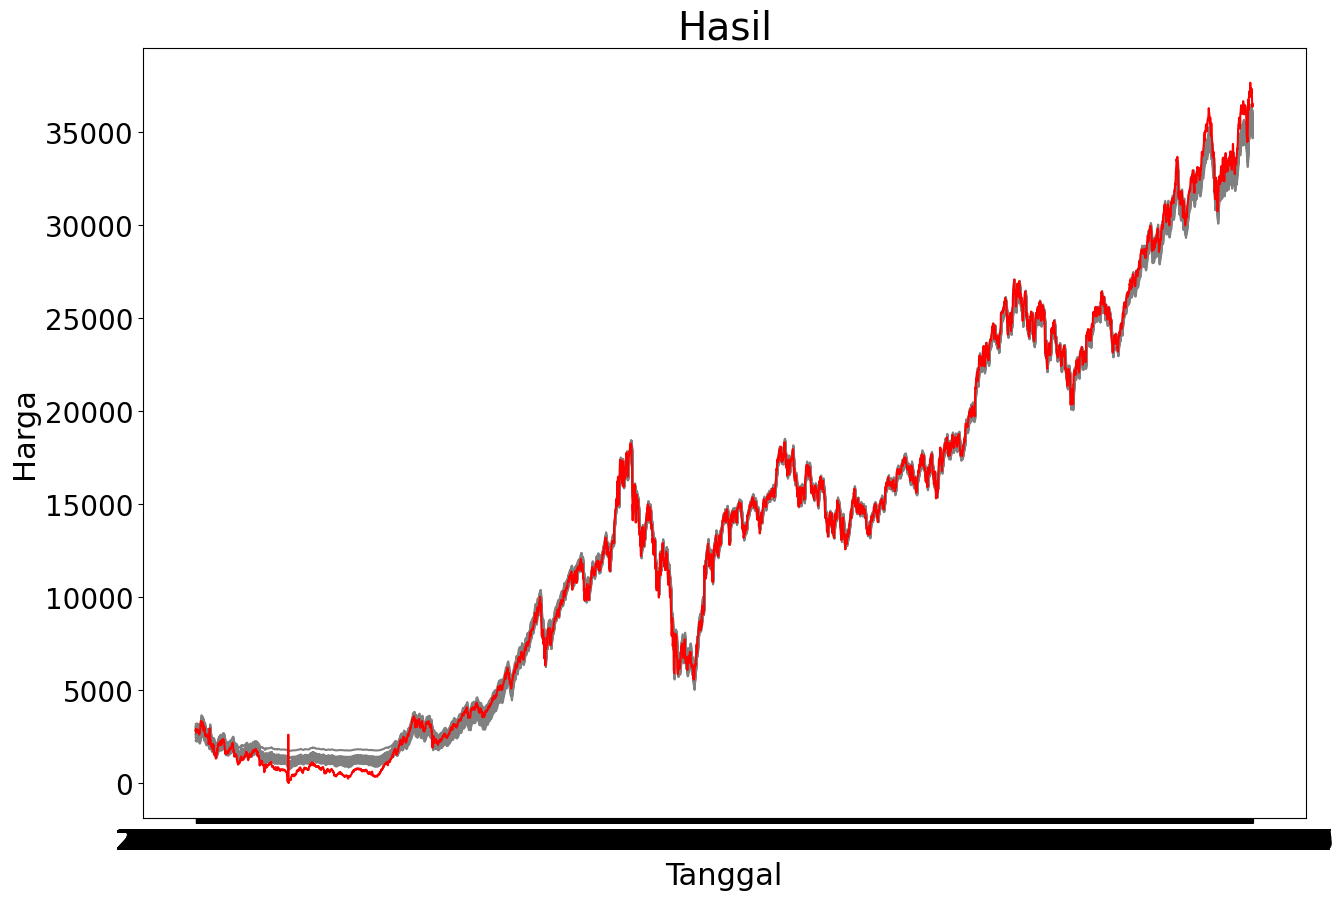

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in traincopy.columns:
  if column != 'Rata2':
    ax.plot(traincopy.index, traincopy[column], label='Prediksi', color='gray')
ax.plot(traincopy.index, y_train2, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

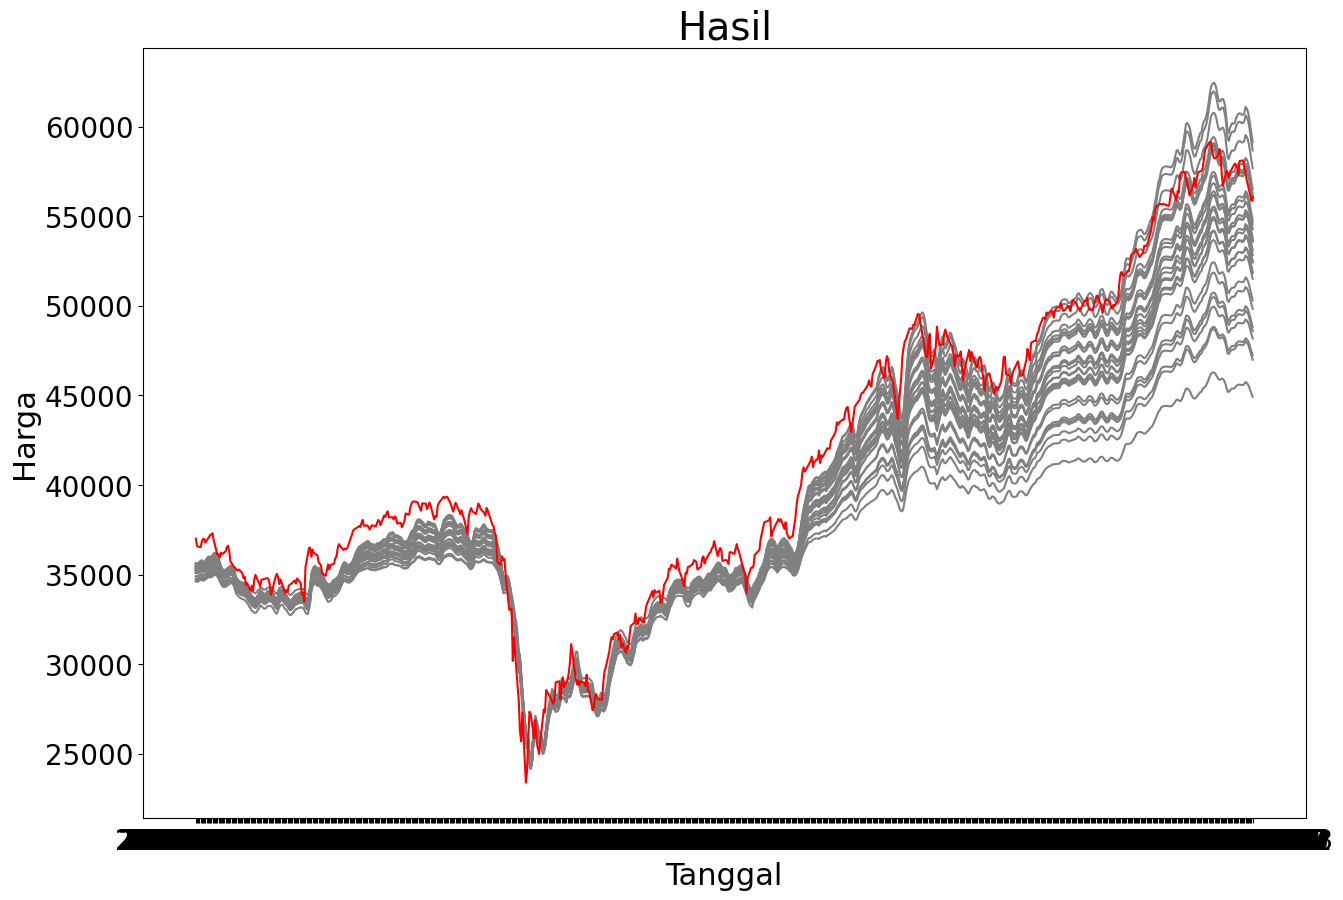

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in val_df.columns:
  if column != 'Rata2':
    ax.plot(val_df.index, val_df[column], label='Prediksi', color='gray')
ax.plot(val_df.index, y_val2, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

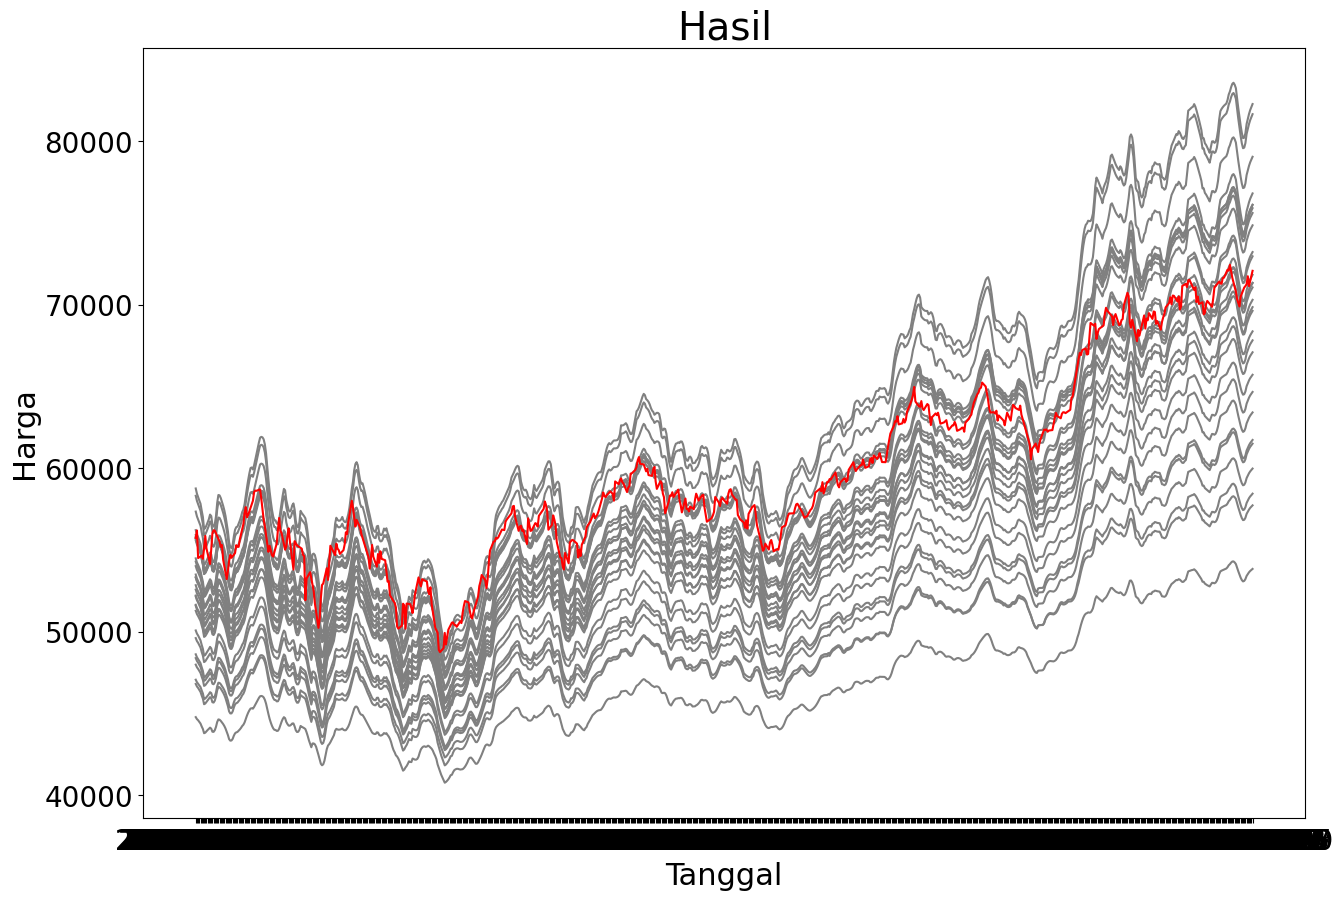

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in test_df.columns:
  if column != 'Rata2':
    ax.plot(test_df.index, test_df[column], label='Prediksi', color='gray')
ax.plot(test_df.index, y_test2, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## Model Hybrid

In [ ]:
traincnn = train_df['Rata2']
valcnn = val_df['Rata2']
testcnn = test_df['Rata2']

traincnn = pd.DataFrame(traincnn)
valcnn = pd.DataFrame(valcnn)
testcnn = pd.DataFrame(testcnn)

traincnn.columns = ['Close']
valcnn.columns = ['Close']
testcnn.columns = ['Close']

traincnn = traincnn.divide(range_value)
valcnn = valcnn.divide(range_value)
testcnn = testcnn.divide(range_value)
traincnn.shape, valcnn.shape, testcnn.shape, df.shape

((7102, 1), (888, 1), (888, 1), (8883, 6))

In [ ]:
padding = traincnn[:2]
df = pd.concat([padding, traincnn, valcnn, testcnn])
df.reset_index(drop=True, inplace=True)
df

Close
0     0.038142
1     0.037735
2     0.038142
3     0.037735
4     0.038143
...        ...
8875  0.952917
8876  0.955983
8877  0.958282
8878  0.959971
8879  0.961801

[8880 rows x 1 columns]

In [ ]:
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()
df['EMA_200']= df['Close'].ewm(span=200, adjust=False).mean()
df['Diff'] = df['EMA_50']-df['EMA_200']
df['sign'] = df['Diff'].apply(lambda x:1 if x>0 else (-1 if x<0 else 0))
df['sign_change'] = df['sign'].diff().apply(lambda x: 1 if x != 0 else 0)
idx1 = df[df['sign_change']==1]

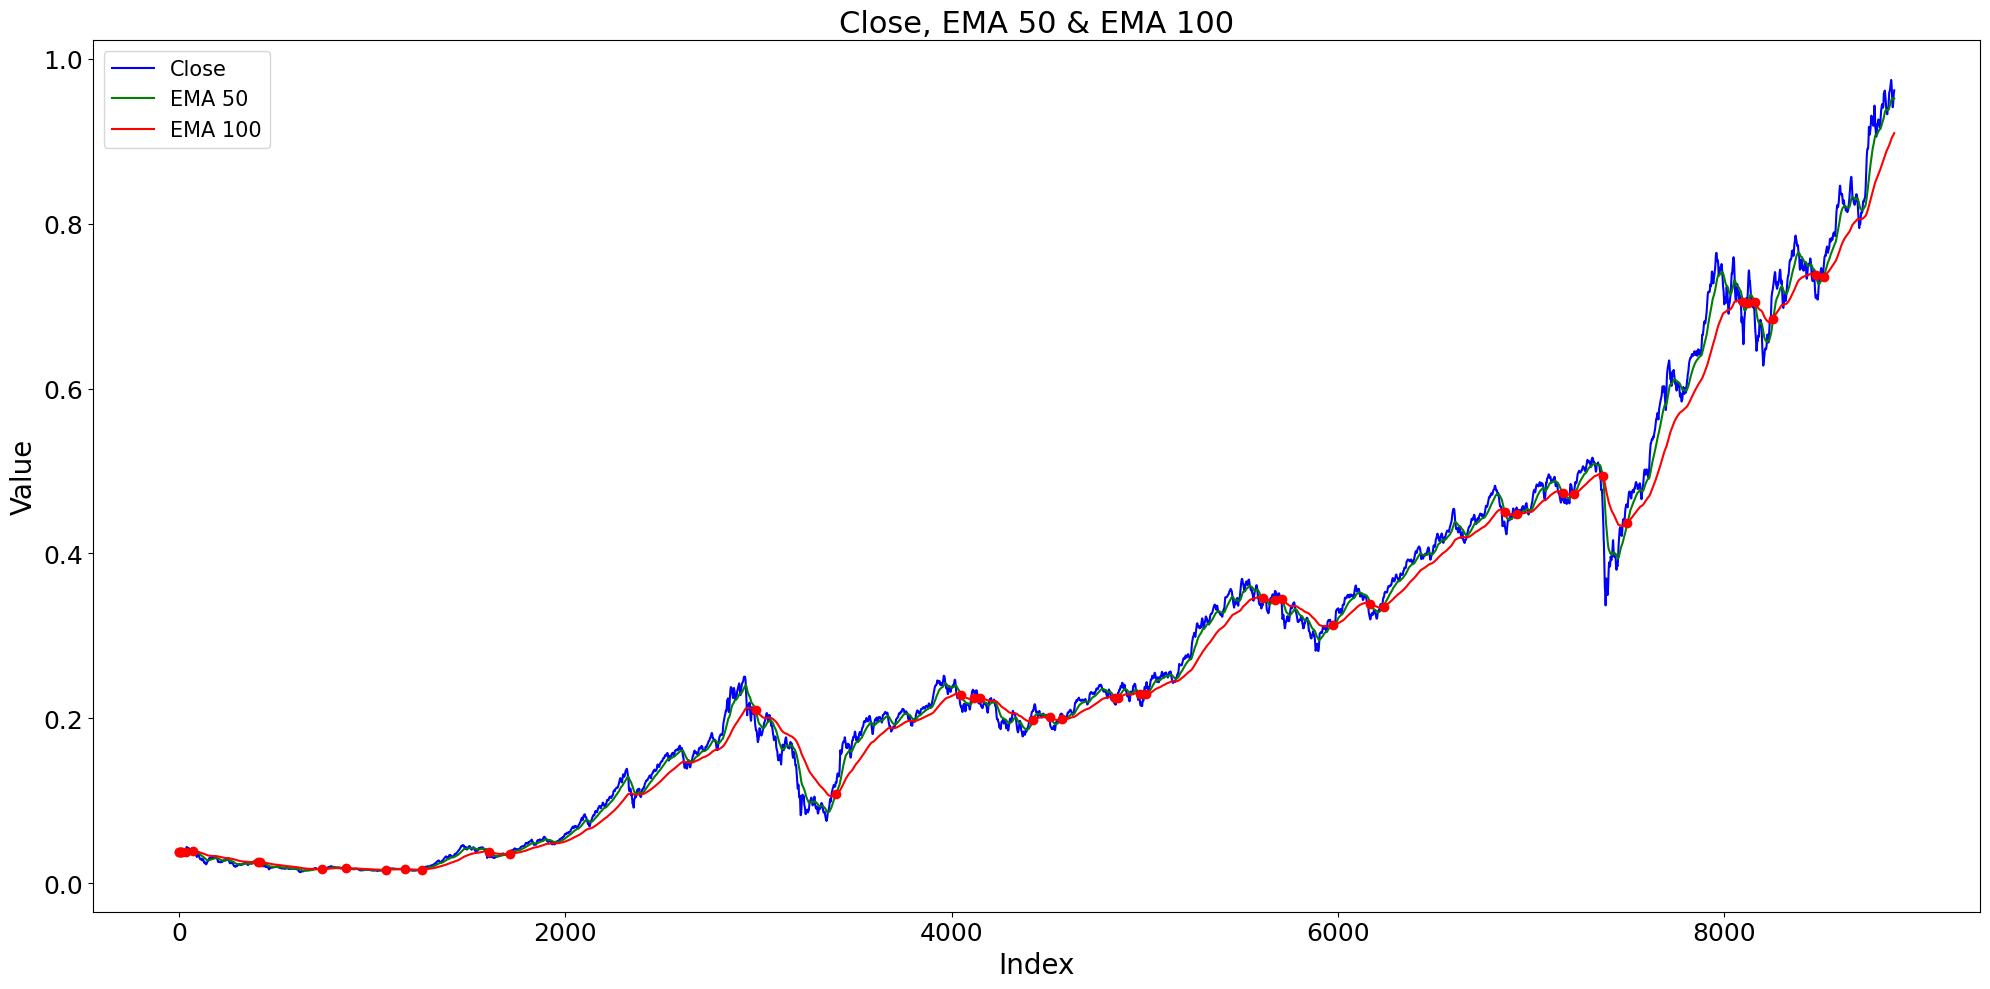

In [ ]:
fig, ax = plt.subplots(figsize = (20,10))
plt.plot(df['Close'], label='Close', color='blue')
plt.plot(df['EMA_50'], label='EMA50', color='green')
plt.plot(df['EMA_200'], label='EMA200', color='red')
plt.plot(idx1.index, df.loc[idx1.index, 'EMA_200'], 'ro', label='Sign Change')
plt.legend(['Close','EMA 50','EMA 100'], fontsize=15)
plt.title('Close, EMA 50 & EMA 100', fontsize=22)
plt.xlabel('Index', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()

## Data Buy Keep Sell


In [ ]:
df['label'] = df.apply(
    lambda row: 'Buy' if row['sign_change'] == 1 and row['EMA_50'] < row['EMA_200'] else
                ('Sell' if row['sign_change'] == 1 and row['EMA_50'] > row['EMA_200'] else 'Keep'),
    axis=1
)
df_buy_sell = df[df['label'] != 'Keep']
df_buy_sell

Close    EMA_50   EMA_200          Diff  sign  sign_change label
1     0.037735  0.038126  0.038138 -1.190918e-05    -1            1   Buy
8     0.038273  0.038143  0.038141  1.624915e-06     1            1  Sell
9     0.037708  0.038126  0.038137 -1.111001e-05    -1            1   Buy
10    0.038513  0.038141  0.038141  3.505023e-07     1            1  Sell
18    0.037753  0.038134  0.038139 -5.439023e-06    -1            1   Buy
39    0.043130  0.038279  0.038141  1.383696e-04     1            1  Sell
74    0.034563  0.038464  0.038494 -3.077514e-05    -1            1   Buy
407   0.027009  0.025504  0.025501  2.830895e-06     1            1  Sell
422   0.024654  0.025514  0.025522 -7.440048e-06    -1            1   Buy
742   0.017777  0.017198  0.017192  5.404544e-06     1            1  Sell
867   0.017066  0.018014  0.018041 -2.724903e-05    -1            1   Buy
1074  0.017317  0.016195  0.016183  1.157258e-05     1            1  Sell
1169  0.015935  0.016671  0.016682 -1.094747e-05    -1            1   Buy
1257  0.017476  0.016257  0.016234  2.304077e-05     1            1  Sell
1605  0.033897  0.037651  0.037734 -8.265001e-05    -1            1   Buy
1715  0.037804  0.035306  0.035284  2.210400e-05     1            1  Sell
2985  0.189124  0.209859  0.210206 -3.469933e-04    -1            1   Buy
3403  0.121937  0.108288  0.108043  2.443117e-04     1            1  Sell
4049  0.214367  0.228190  0.228232 -4.241326e-05    -1            1   Buy
4117  0.231849  0.224170  0.224162  7.839547e-06     1            1  Sell
4147  0.218762  0.224602  0.224671 -6.943152e-05    -1            1   Buy
4423  0.209581  0.197841  0.197806  3.547528e-05     1            1  Sell
4511  0.190898  0.200789  0.201087 -2.976100e-04    -1            1   Buy
4571  0.204968  0.198743  0.198587  1.560048e-04     1            1  Sell
4848  0.217286  0.224656  0.224855 -1.990958e-04    -1            1   Buy
4861  0.230240  0.224945  0.224859  8.587272e-05     1            1  Sell
4975  0.218685  0.229577  0.229654 -7.704142e-05    -1            1   Buy
5007  0.240618  0.229103  0.228810  2.929528e-04     1            1  Sell
5609  0.336696  0.344992  0.345235 -2.430160e-04    -1            1   Buy
5672  0.351163  0.343762  0.343661  1.013539e-04     1            1  Sell
5712  0.321477  0.344111  0.344452 -3.410608e-04    -1            1   Buy
5973  0.316939  0.312551  0.312500  5.148388e-05     1            1  Sell
6167  0.319821  0.338559  0.338819 -2.603872e-04    -1            1   Buy
6236  0.346408  0.335382  0.335287  9.502681e-05     1            1  Sell
6865  0.430721  0.450232  0.450384 -1.515996e-04    -1            1   Buy
6926  0.453860  0.447734  0.447562  1.717604e-04     1            1  Sell
7163  0.465467  0.473623  0.473701 -7.824820e-05    -1            1   Buy
7220  0.474981  0.471995  0.471981  1.406806e-05     1            1  Sell
7370  0.455065  0.493861  0.494122 -2.607427e-04    -1            1   Buy
7498  0.456573  0.437059  0.436734  3.246811e-04     1            1  Sell
8096  0.663158  0.704785  0.704801 -1.677664e-05    -1            1   Buy
8124  0.732549  0.703479  0.703211  2.681713e-04     1            1  Sell
8158  0.677149  0.704513  0.704994 -4.809809e-04    -1            1   Buy
8253  0.725071  0.685384  0.684302  1.081924e-03     1            1  Sell
8473  0.709825  0.737321  0.737790 -4.685326e-04    -1            1   Buy
8515  0.752156  0.736156  0.735759  3.975951e-04     1            1  Sell

In [ ]:
df['label1'] = df.apply(
    lambda row: 1 if row['sign_change'] == 1 and row['EMA_50'] < row['EMA_200'] else
                (-1 if row['sign_change'] == 1 and row['EMA_50'] > row['EMA_200'] else 0),
    axis=1
)
df_buy_sell1 = df[df['label1'] != 0]
df_buy_sell1

Close    EMA_50   EMA_200          Diff  sign  sign_change label  \
1     0.037735  0.038126  0.038138 -1.190918e-05    -1            1   Buy   
8     0.038273  0.038143  0.038141  1.624915e-06     1            1  Sell   
9     0.037708  0.038126  0.038137 -1.111001e-05    -1            1   Buy   
10    0.038513  0.038141  0.038141  3.505023e-07     1            1  Sell   
18    0.037753  0.038134  0.038139 -5.439023e-06    -1            1   Buy   
39    0.043130  0.038279  0.038141  1.383696e-04     1            1  Sell   
74    0.034563  0.038464  0.038494 -3.077514e-05    -1            1   Buy   
407   0.027009  0.025504  0.025501  2.830895e-06     1            1  Sell   
422   0.024654  0.025514  0.025522 -7.440048e-06    -1            1   Buy   
742   0.017777  0.017198  0.017192  5.404544e-06     1            1  Sell   
867   0.017066  0.018014  0.018041 -2.724903e-05    -1            1   Buy   
1074  0.017317  0.016195  0.016183  1.157258e-05     1            1  Sell   
1169  0.015935  0.016671  0.016682 -1.094747e-05    -1            1   Buy   
1257  0.017476  0.016257  0.016234  2.304077e-05     1            1  Sell   
1605  0.033897  0.037651  0.037734 -8.265001e-05    -1            1   Buy   
1715  0.037804  0.035306  0.035284  2.210400e-05     1            1  Sell   
2985  0.189124  0.209859  0.210206 -3.469933e-04    -1            1   Buy   
3403  0.121937  0.108288  0.108043  2.443117e-04     1            1  Sell   
4049  0.214367  0.228190  0.228232 -4.241326e-05    -1            1   Buy   
4117  0.231849  0.224170  0.224162  7.839547e-06     1            1  Sell   
4147  0.218762  0.224602  0.224671 -6.943152e-05    -1            1   Buy   
4423  0.209581  0.197841  0.197806  3.547528e-05     1            1  Sell   
4511  0.190898  0.200789  0.201087 -2.976100e-04    -1            1   Buy   
4571  0.204968  0.198743  0.198587  1.560048e-04     1            1  Sell   
4848  0.217286  0.224656  0.224855 -1.990958e-04    -1            1   Buy   
4861  0.230240  0.224945  0.224859  8.587272e-05     1            1  Sell   
4975  0.218685  0.229577  0.229654 -7.704142e-05    -1            1   Buy   
5007  0.240618  0.229103  0.228810  2.929528e-04     1            1  Sell   
5609  0.336696  0.344992  0.345235 -2.430160e-04    -1            1   Buy   
5672  0.351163  0.343762  0.343661  1.013539e-04     1            1  Sell   
5712  0.321477  0.344111  0.344452 -3.410608e-04    -1            1   Buy   
5973  0.316939  0.312551  0.312500  5.148388e-05     1            1  Sell   
6167  0.319821  0.338559  0.338819 -2.603872e-04    -1            1   Buy   
6236  0.346408  0.335382  0.335287  9.502681e-05     1            1  Sell   
6865  0.430721  0.450232  0.450384 -1.515996e-04    -1            1   Buy   
6926  0.453860  0.447734  0.447562  1.717604e-04     1            1  Sell   
7163  0.465467  0.473623  0.473701 -7.824820e-05    -1            1   Buy   
7220  0.474981  0.471995  0.471981  1.406806e-05     1            1  Sell   
7370  0.455065  0.493861  0.494122 -2.607427e-04    -1            1   Buy   
7498  0.456573  0.437059  0.436734  3.246811e-04     1            1  Sell   
8096  0.663158  0.704785  0.704801 -1.677664e-05    -1            1   Buy   
8124  0.732549  0.703479  0.703211  2.681713e-04     1            1  Sell   
8158  0.677149  0.704513  0.704994 -4.809809e-04    -1            1   Buy   
8253  0.725071  0.685384  0.684302  1.081924e-03     1            1  Sell   
8473  0.709825  0.737321  0.737790 -4.685326e-04    -1            1   Buy   
8515  0.752156  0.736156  0.735759  3.975951e-04     1            1  Sell   

      label1  
1          1  
8         -1  
9          1  
10        -1  
18         1  
39        -1  
74         1  
407       -1  
422        1  
742       -1  
867        1  
1074      -1  
1169       1  
1257      -1  
1605       1  
1715      -1  
2985       1  
3403      -1  
4049       1  
4117      -1  
4147       1  
4423      -1  
4511       1  
4571      -1  
4848       1  

In [ ]:
datacnn = df.copy()
datacnn = df[['Close','label1']]
datacnn

Close  label1
0     0.038142       0
1     0.037735       1
2     0.038142       0
3     0.037735       0
4     0.038143       0
...        ...     ...
8875  0.952917       0
8876  0.955983       0
8877  0.958282       0
8878  0.959971       0
8879  0.961801       0

[8880 rows x 2 columns]

In [ ]:
def windowed_df_close(data, n):
    dates = []
    data_as_np = data.to_numpy()
    l = data.shape[0]
    dates = []
    X, Y = [], []
    for i in range(n, l):
        indexes = data.index[i-n:i+1]
        row = [r for r in data_as_np[i-n:i]]
        X.append(row)
        y = data_as_np[i][0]
        Y.append(y)
        dates.append(indexes[-1])
    return np.array(X), np.array(Y), np.array(dates)

X_pred, y_pred, dates_pred = windowed_df_close(datacnn, 2)
n_total2 = len(X_pred)
Mq_80 = int(n_total2*0.8)
Mq_90 = int(n_total2*0.9)
dates_pred_train, X_pred_train, y_pred_train = dates_pred[:Mq_80], X_pred[:Mq_80], y_pred[:Mq_80]
dates_pred_val, X_pred_val, y_pred_val = dates_pred[Mq_80:Mq_90],  X_pred[Mq_80:Mq_90], y_pred[Mq_80:Mq_90]
dates_pred_test, X_pred_test, y_pred_test = dates_pred[Mq_90:],  X_pred[Mq_90:], y_pred[Mq_90:]

In [ ]:
datacnn

Close  label1
0     0.038142       0
1     0.037735       1
2     0.038142       0
3     0.037735       0
4     0.038143       0
...        ...     ...
8875  0.952917       0
8876  0.955983       0
8877  0.958282       0
8878  0.959971       0
8879  0.961801       0

[8880 rows x 2 columns]

In [ ]:
X_pred_train.shape, X_pred_val.shape, X_pred_test.shape, y_pred_test.shape

((7102, 2, 2), (888, 2, 2), (888, 2, 2), (888,))

In [ ]:
datafull2 = data_full.copy()
datafull2.index = datafull2['Date']
datafull2 = data_full['Close']
datafull2 = datafull2[3:]
datafull2 = datafull2.rename(columns={'^BSESN': 'Close'})

datafull2['EMA_50'] = datafull2['Close'].ewm(span=50, adjust=False).mean()
datafull2['EMA_200']= datafull2['Close'].ewm(span=200, adjust=False).mean()
datafull2['Diff'] = datafull2['EMA_50']-datafull2['EMA_200']
datafull2['sign'] = datafull2['Diff'].apply(lambda x:1 if x>0 else (-1 if x<0 else 0))
datafull2['sign_change'] = datafull2['sign'].diff().apply(lambda x: 1 if x != 0 else 0)
idx1 = datafull2[datafull2['sign_change']==1]
datafull2['label'] = datafull2.apply(
    lambda row: 'Buy' if row['sign_change'] == 1 and row['EMA_50'] < row['EMA_200'] else
                ('Sell' if row['sign_change'] == 1 and row['EMA_50'] > row['EMA_200'] else 'Keep'),
    axis=1
)
datafull2_buy_sell = datafull2[datafull2['label'] != 'Keep']
datafull2['label1'] = datafull2.apply(
    lambda row: 1 if row['sign_change'] == 1 and row['EMA_50'] < row['EMA_200'] else
                (-1 if row['sign_change'] == 1 and row['EMA_50'] > row['EMA_200'] else 0),
    axis=1
)
datafull2_buy_sell1 = datafull2[datafull2['label1'] != 0]

datafull2 = datafull2[['Close', 'label1']]
datafull2['Close'] = pd.to_numeric(datafull2['Close'])
datafull2['label1'] = pd.to_numeric(datafull2['label1'])

X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
datafull2

Ticker         Close  label1
Date                        
2000-01-07  0.038852       0
2000-01-08  0.039330      -1
2000-01-09  0.039808       0
2000-01-10  0.040286       0
2000-01-11  0.037221       0
...              ...     ...
2024-04-25  0.990354       0
2024-04-26  0.981943       0
2024-04-27  0.986274       0
2024-04-28  0.990605       0
2024-04-29  0.994935       0

[8880 rows x 2 columns]

## CNN HYPERPARAMETER TUNING

In [ ]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import Conv1D, MaxPooling2D, Flatten, Dense, Dropout, Reshape

def build_cnn_model(hp):
    model = Sequential()

    model.add(Conv1D(
        filters=hp.Choice('filters', values=[8, 16, 32, 64]),
        kernel_size=2,
        activation=hp.Choice('activation_conv', values=['relu', 'tanh']),
        padding="same",
        input_shape=(2, 2)
    ))

    model.add(Flatten())

    model.add(Dense(
        units=hp.Choice('dense_units', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation_dense', values=['relu', 'tanh'])
    ))

    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))

    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model

tuner = kt.RandomSearch(
    build_cnn_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    directory='random_search_cnn',
    project_name='cnn_tuning_activation'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

tuner.search(
    X_pred_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_pred_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Menampilkan hasil terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Hyperparameters:
- Filters: {best_hps.get('filters')}
- Activation (Conv1D): {best_hps.get('activation_conv')}
- Dense Layer Units: {best_hps.get('dense_units')}
- Activation (Dense): {best_hps.get('activation_dense')}
- Dropout: {best_hps.get('dropout')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

Trial 60 Complete [00h 00m 36s]
val_loss: 0.0012052886886522174

Best val_loss So Far: 0.0001779458689270541
Total elapsed time: 00h 57m 46s

Best Hyperparameters:
- Filters: 8
- Activation (Conv1D): relu
- Dense Layer Units: 64
- Activation (Dense): relu
- Dropout: 0.1
- Learning Rate: 0.001



In [ ]:
from kerastuner.tuners import BayesianOptimization
from kerastuner import HyperParameters as hp

def build_cnn_model(hp):
    model = Sequential()
    model.add(Reshape((2, 2), input_shape=(2, 2)))
    model.add(Conv1D(
        filters=hp.Choice('filters', values=[8, 16, 32, 64]),
        kernel_size=2,
        activation=hp.Choice('activation_conv', values=['relu', 'tanh']),
        padding="same"
    ))
    model.add(Flatten())
    model.add(Dense(
        units=hp.Choice('dense_units', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation_dense', values=['relu', 'tanh'])
    ))
    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))
    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model


bayesian_opt_tuner = BayesianOptimization(
    build_cnn_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    directory='bayesian cnn',
    project_name='kerastuner_bayesian_cnn',
    overwrite=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

bayesian_opt_tuner.search(
    X_pred_train, y_train,
    epochs=150,
    validation_data=(X_pred_val, y_val),
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

best_cnn_models = bayesian_opt_tuner.get_best_models(num_models=1)
model = best_cnn_models[0]

Trial 60 Complete [00h 00m 46s]
val_loss: 0.00020473235053941607

Best val_loss So Far: 0.00017965146980714053
Total elapsed time: 00h 48m 35s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_trial = bayesian_opt_tuner.oracle.get_best_trials(num_trials=1)[0]
best_hyperparameters = best_trial.hyperparameters.values
print("Best Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

best_cnn_models = bayesian_opt_tuner.get_best_models(num_models=1)
model = best_cnn_models[0]

Best Hyperparameters:
filters: 64
activation_conv: relu
dense_units: 128
activation_dense: tanh
dropout: 0.2
learning_rate: 0.01


## CNN MODEL

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datacnn, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling2D, Flatten, Dense, Dropout, Reshape

cnn = Sequential()
cnn.add(Reshape((2, 2), input_shape=(2, 2)))
cnn.add(Conv1D(8, kernel_size=2, activation="relu", padding="same"))
cnn.add(Flatten())
cnn.add(Dense(64, activation="relu"))
cnn.add(Dropout(0.1))
cnn.add(Dense(1, activation="linear"))

cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 2, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 2, 8)           │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,193 (4.66 KB)

 Trainable params: 1,193 (4.66 KB)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("cnnrs_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(cnn)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"cnnrs_weights/best_cnnrs_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")

best_history = bm_histories[best_iter]

plt.figure(figsize=(10, 5))
plt.plot(best_history['loss'], label='Train Loss', color='blue')
plt.plot(best_history['val_loss'], label='Validation Loss', color='orange')
plt.title(f'Loss per Epoch pada Iterasi ke-{best_iter+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.757797   0.764220   0.749654   0.762070   0.766882   0.762013   
2021-11-25   0.754181   0.760163   0.745915   0.758030   0.763025   0.758170   
2021-11-26   0.751036   0.756704   0.742722   0.754603   0.759719   0.754847   
2021-11-27   0.749019   0.754275   0.740498   0.752108   0.757454   0.752658   
2021-11-28   0.746799   0.751977   0.738363   0.749838   0.755218   0.750353   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.970987   0.992685   0.957187   0.984914   0.985985   0.984836   
2024-04-26   0.973861   0.996404   0.960648   0.988703   0.989425   0.987856   
2024-04-27   0.976827   0.999570   0.963506   0.991773   0.992453   0.990723   
2024-04-28   0.979070   1.002192   0.965908   0.994378   0.994920   0.992977   
2024-04-29   0.980719   1.004130   0.967686   0.996307   0.996742   0.994638   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_INDIA.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_INDIA.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_INDIA.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

#bm_prediction_df.to_csv('hasilprediksicnnrs_INDIA.csv')
#bm_train_predictions.to_csv('hasilprediksicnnrs_train_INDIA.csv')
#bm_val_predictions.to_csv('hasilprediksicnnrs_val_INDIA.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksicnnrs_INDIA.csv')
bm_train_predictions.to_csv('hasilprediksicnnrs_train_INDIA.csv')
bm_val_predictions.to_csv('hasilprediksicnnrs_val_INDIA.csv')


In [ ]:
!zip -r cnnrs_weights.zip /content/cnnrs_weights
from google.colab import files
files.download("cnnrs_weights.zip")

  adding: content/cnnrs_weights/ (stored 0%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_27.weights.h5 (deflated 64%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_5.weights.h5 (deflated 63%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_9.weights.h5 (deflated 63%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_28.weights.h5 (deflated 63%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_7.weights.h5 (deflated 63%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_18.weights.h5 (deflated 63%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_1.weights.h5 (deflated 63%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_14.weights.h5 (deflated 63%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_22.weights.h5 (deflated 64%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_10.weights.h5 (deflated 64%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_21.weights.h5 (deflated 63%)
  adding: content/cnnrs_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

344.8518082866777 218446.3792220047 467.38247637454776 402471145602970.5
1232.8223935605556 2537104.780288346 1592.8291748609913 0.028646589923117933
2427.467799831087 6773561.325827143 2602.606640625345 0.04105160199121026


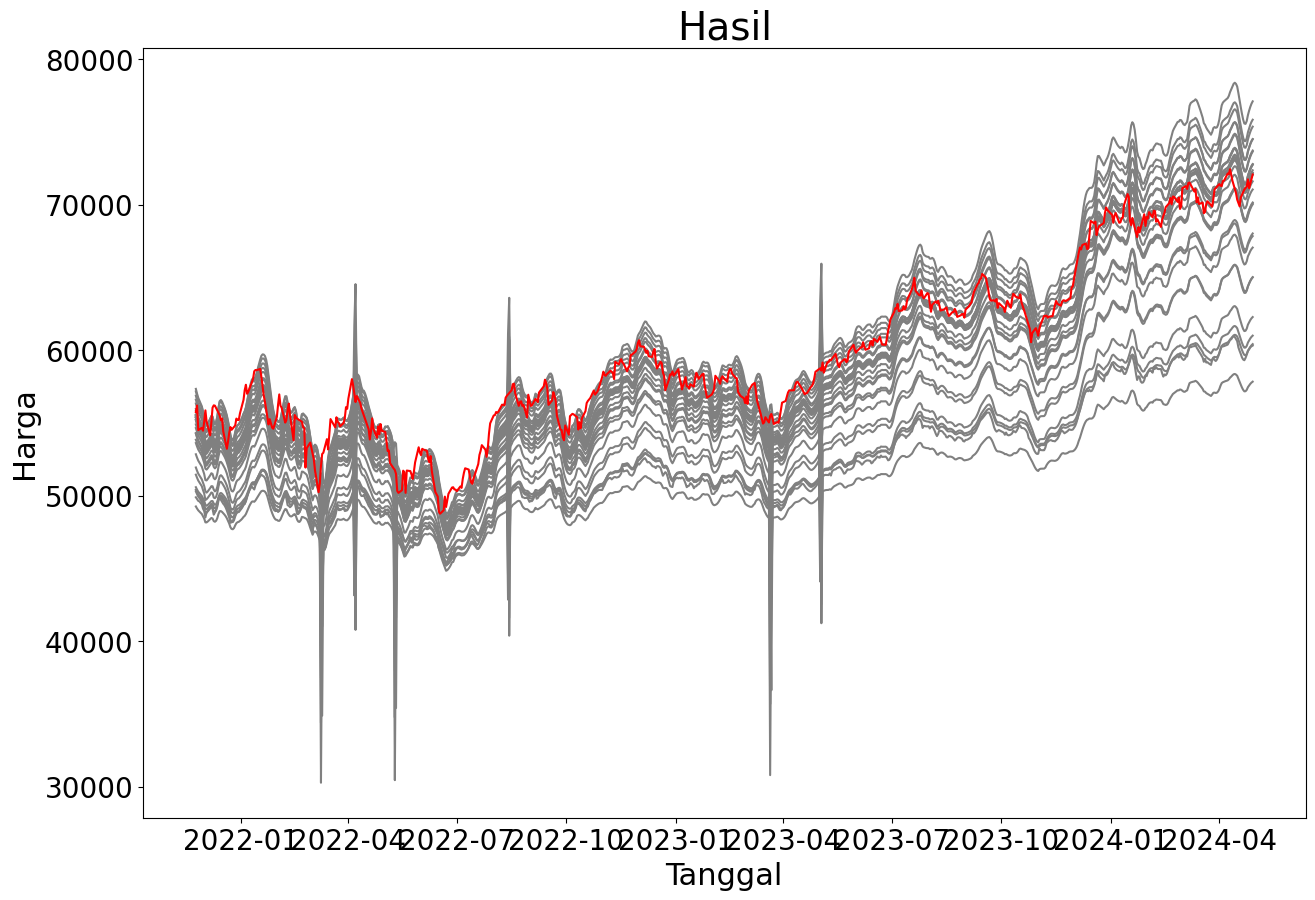

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

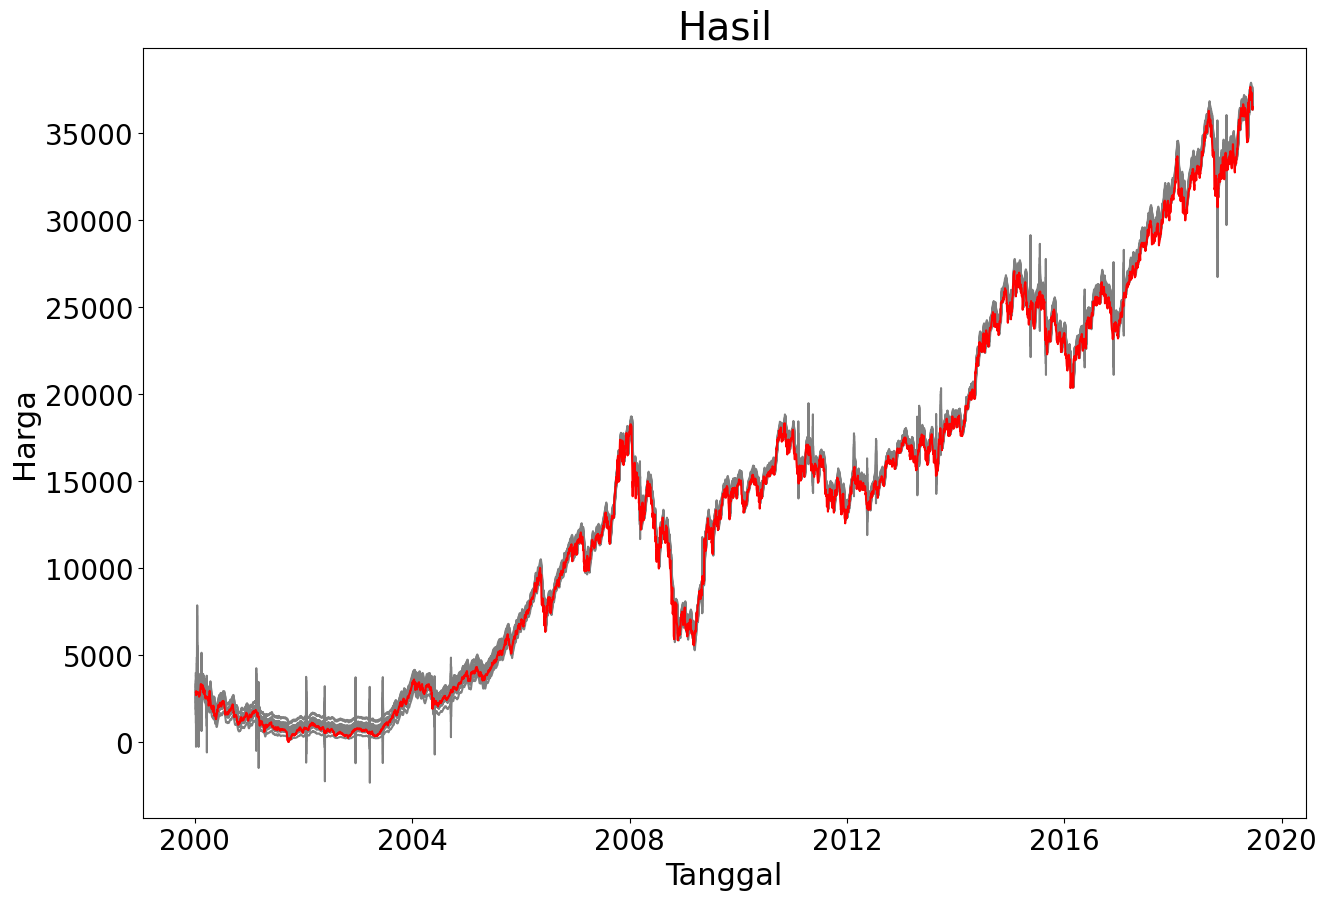

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## CNN dengan Bayesian

In [ ]:
X_pred, y_pred, dates_pred = windowed_df_close(datacnn, 2)
n_total2 = len(X_pred)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_pred_train, X_pred_train, y_pred_train = dates_pred[:Mqn_80], X_pred[:Mqn_80], y_pred[:Mqn_80]
dates_pred_val, X_pred_val, y_pred_val = dates_pred[Mqn_80:Mqn_90],  X_pred[Mqn_80:Mqn_90], y_pred[Mqn_80:Mqn_90]
dates_pred_test, X_pred_test, y_pred_test = dates_pred[Mqn_90:],  X_pred[Mqn_90:], y_pred[Mqn_90:]
print(X_pred_train.shape, X_pred_val.shape, X_pred_test.shape, y_pred_test.shape)
print(y_pred_train.shape, y_pred_val.shape, y_pred_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
cnn = Sequential()
cnn.add(Reshape((2, 2), input_shape=(2, 2)))
cnn.add(Conv1D(64, kernel_size=2, activation="relu", padding="same"))
cnn.add(Flatten())
cnn.add(Dense(128, activation="tanh"))
cnn.add(Dropout(0.2))
cnn.add(Dense(1, activation="linear"))

cnn.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 2, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 64)          │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("cnnbo_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(cnn)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"cnnbo_weights/best_cnnrs_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")

best_history = bm_histories[best_iter]

plt.figure(figsize=(10, 5))
plt.plot(best_history['loss'], label='Train Loss', color='blue')
plt.plot(best_history['val_loss'], label='Validation Loss', color='orange')
plt.title(f'Loss per Epoch pada Iterasi ke-{best_iter+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.797125   0.783819   0.788060   0.779522   0.789931   0.794290   
2021-11-25   0.792545   0.779497   0.783679   0.775264   0.785553   0.789837   
2021-11-26   0.788655   0.775807   0.779938   0.771639   0.781811   0.786035   
2021-11-27   0.785880   0.773268   0.777324   0.769072   0.779209   0.783379   
2021-11-28   0.783325   0.770775   0.774827   0.766676   0.776702   0.780841   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   1.050138   1.029827   1.029800   1.016530   1.035930   1.049563   
2024-04-26   1.054391   1.033647   1.033644   1.020473   1.039846   1.053703   
2024-04-27   1.057876   1.037013   1.036943   1.023758   1.043225   1.057262   
2024-04-28   1.060815   1.039753   1.039663   1.026505   1.046003   1.060193   
2024-04-29   1.062990   1.041775   1.041672   1.028538   1.048055   1.062359   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_INDIA.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_INDIA.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_INDIA.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

bm_prediction_df.to_csv('hasilprediksicnnbo_INDIA.csv')
bm_train_predictions.to_csv('hasilprediksicnnbo_train_INDIA.csv')
bm_val_predictions.to_csv('hasilprediksicnnbo_val_INDIA.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksicnnbo_INDIA.csv')
bm_train_predictions.to_csv('hasilprediksicnnbo_train_INDIA.csv')
bm_val_predictions.to_csv('hasilprediksicnnbo_val_INDIA.csv')


In [ ]:
!zip -r cnnbo_weights.zip /content/cnnbo_weights
from google.colab import files
files.download("cnnbo_weights.zip")

  adding: content/cnnbo_weights/ (stored 0%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_27.weights.h5 (deflated 20%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_5.weights.h5 (deflated 19%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_9.weights.h5 (deflated 17%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_28.weights.h5 (deflated 19%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_7.weights.h5 (deflated 19%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_18.weights.h5 (deflated 20%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_1.weights.h5 (deflated 19%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_14.weights.h5 (deflated 17%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_22.weights.h5 (deflated 21%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_10.weights.h5 (deflated 20%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_21.weights.h5 (deflated 21%)
  adding: content/cnnbo_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

358.9222188617458 220503.49972248118 469.57800174463154 119984128972465.0
719.2558670731289 987585.6592890321 993.7734446487449 0.018742824739010667
1520.3674998240394 4085554.3179632854 2021.2754186313366 0.024373225169315487


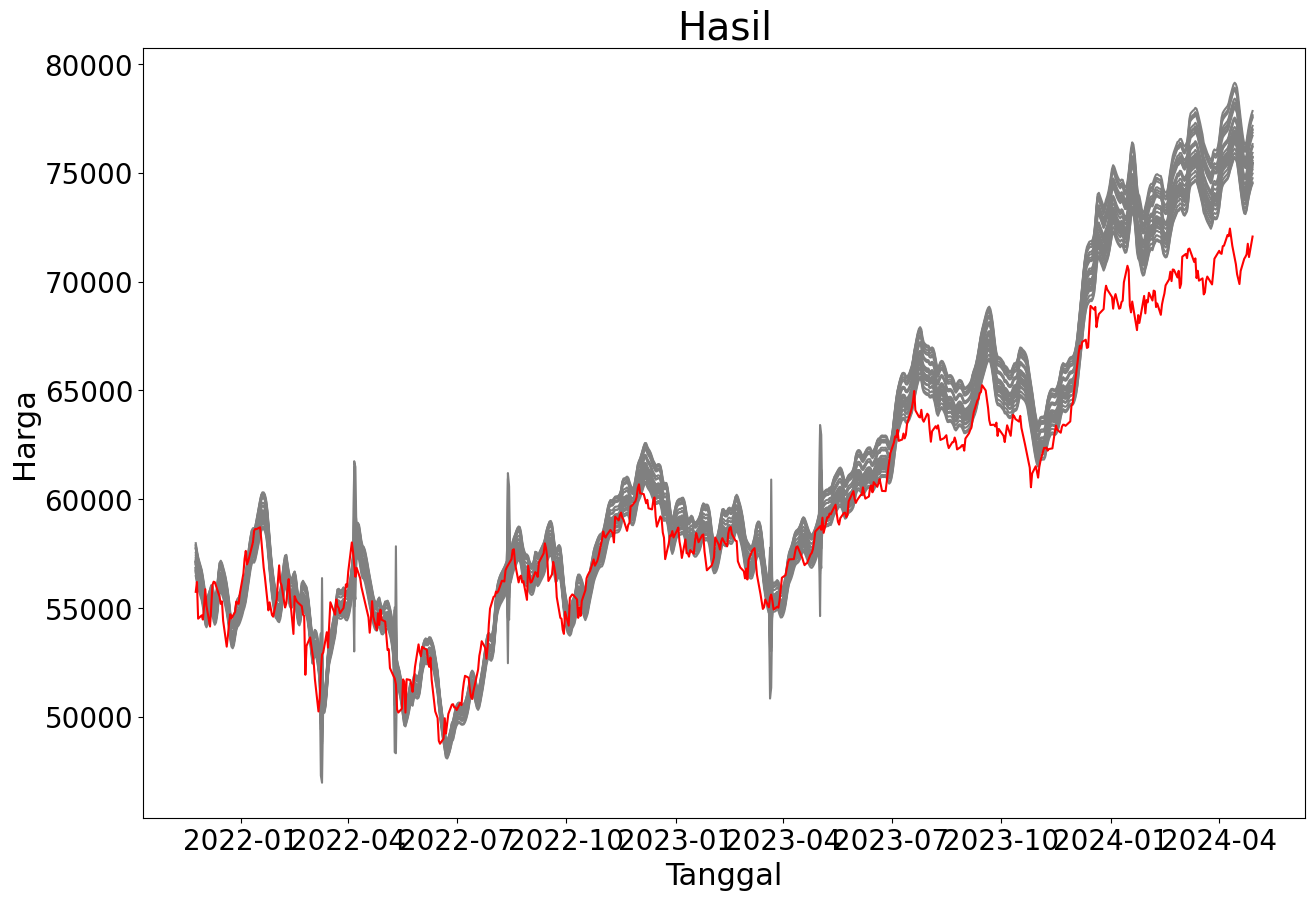

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

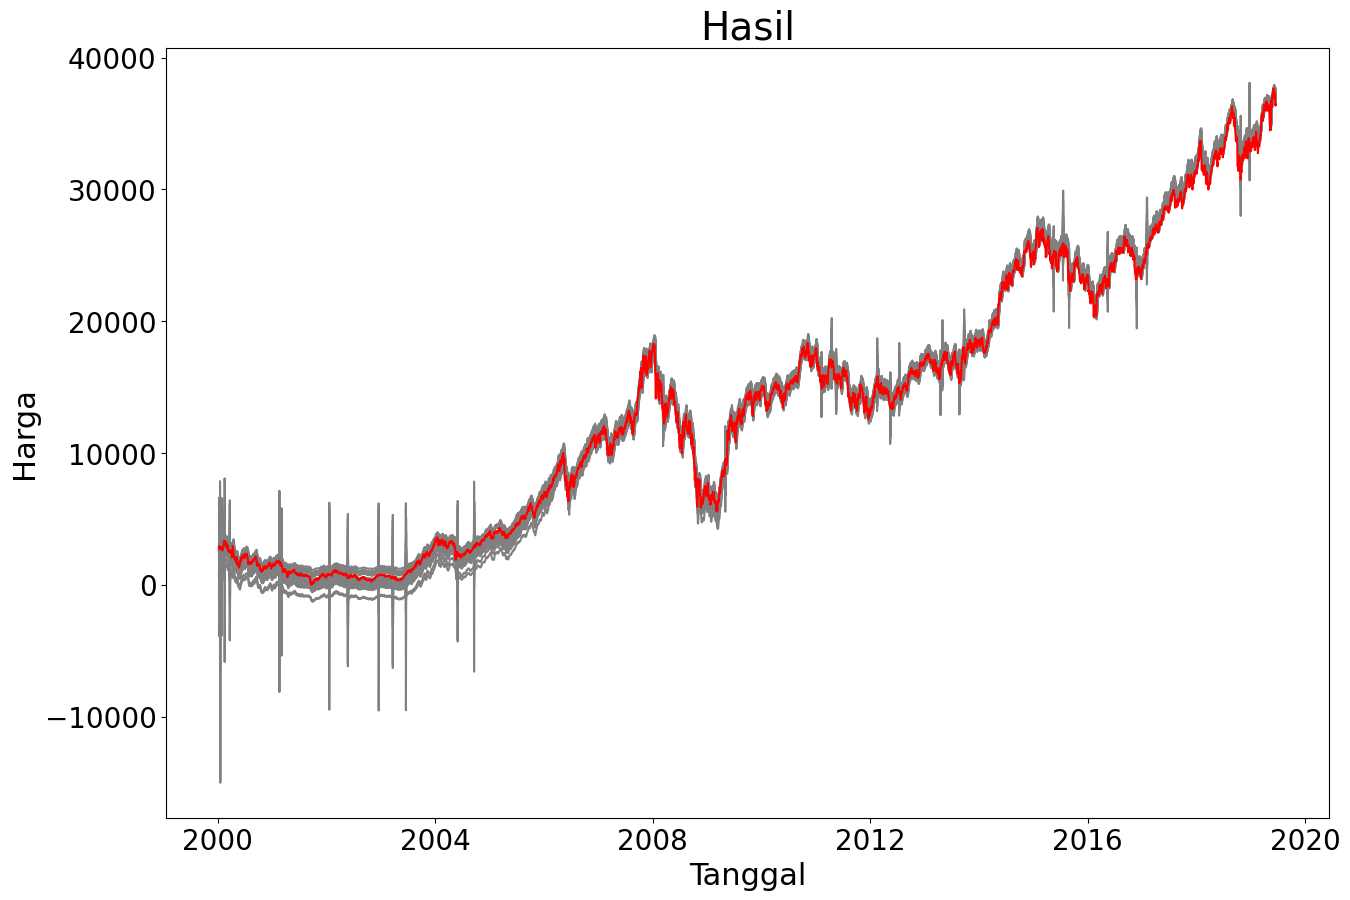

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## ANN

In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import Conv1D, MaxPooling2D, Flatten, Dense, Dropout, Reshape

def build_ann_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(2,2)))

    model.add(Dense(
        units=hp.Choice('dense_units_1', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid'])
    ))

    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))

    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
        ),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model

tuner = kt.RandomSearch(
    build_ann_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    directory='random_search_ann',
    project_name='ann_tuning'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

tuner.search(
    X_pred_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_pred_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Hyperparameters:
- Dense Layer 1 Units: {best_hps.get('dense_units_1')}
- Activation 1: {best_hps.get('activation_1')}
- Dropout: {best_hps.get('dropout')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

Trial 60 Complete [00h 02m 26s]
val_loss: 0.022027194499969482

Best val_loss So Far: 0.0001583934499649331
Total elapsed time: 01h 12m 01s

Best Hyperparameters:
- Dense Layer 1 Units: 128
- Activation 1: sigmoid
- Dropout: 0.1
- Learning Rate: 0.01



In [ ]:
from kerastuner.tuners import BayesianOptimization
from kerastuner import HyperParameters as hp
def build_ann_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(2, 2)))

    model.add(Dense(
        units=hp.Choice('dense_units_1', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid'])
    ))

    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))

    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
        ),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model

bayesian_opt_tuner = kt.BayesianOptimization(
    build_ann_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    overwrite=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

bayesian_opt_tuner.search(
    X_pred_train, y_train,
    epochs=150,
    validation_data=(X_pred_val, y_val),
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

best_ann_models = bayesian_opt_tuner.get_best_models(num_models=1)
model = best_ann_models[0]

print("\n--- Best Model Summary ---")
model.summary()

best_trial = bayesian_opt_tuner.oracle.get_best_trials(num_trials=1)[0]
best_hyperparameters = best_trial.hyperparameters.values
print("\nBest Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

Trial 60 Complete [00h 01m 05s]
val_loss: 0.00016173595213331282

Best val_loss So Far: 0.00016173595213331282
Total elapsed time: 00h 53m 24s

--- Best Model Summary ---


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 385 (1.50 KB)

 Trainable params: 385 (1.50 KB)

 Non-trainable params: 0 (0.00 B)


Best Hyperparameters:
dense_units_1: 64
activation_1: sigmoid
dropout: 0.1
learning_rate: 0.01


In [ ]:
ann = Sequential()
ann.add(Flatten(input_shape=(2,2)))
ann.add(Dense(128, activation='sigmoid'))
ann.add(Dropout(0.1))
ann.add(Dense(1, activation='linear'))

ann.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

ann.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("annrs_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(ann)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"annrs_weights/best_annrs_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")

best_history = bm_histories[best_iter]

plt.figure(figsize=(10, 5))
plt.plot(best_history['loss'], label='Train Loss', color='blue')
plt.plot(best_history['val_loss'], label='Validation Loss', color='orange')
plt.title(f'Loss per Epoch pada Iterasi ke-{best_iter+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.784920   0.789333   0.781798   0.792152   0.792102   0.788746   
2021-11-25   0.781388   0.785778   0.778451   0.788124   0.788383   0.785102   
2021-11-26   0.778394   0.782763   0.775611   0.784719   0.785230   0.782016   
2021-11-27   0.776107   0.780462   0.773438   0.782121   0.782825   0.779659   
2021-11-28   0.774198   0.778536   0.771625   0.779959   0.780814   0.777694   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.915077   0.918546   0.900608   0.949896   0.929084   0.924700   
2024-04-26   0.916659   0.920069   0.901974   0.951932   0.930719   0.926355   
2024-04-27   0.917793   0.921161   0.902951   0.953395   0.931895   0.927542   
2024-04-28   0.918799   0.922128   0.903816   0.954694   0.932935   0.928593   
2024-04-29   0.919539   0.922840   0.904453   0.955650   0.933700   0.929368   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_INDIA.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_INDIA.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_INDIA.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

#bm_prediction_df.to_csv('hasilprediksicnnbo_INDIA.csv')
#bm_train_predictions.to_csv('hasilprediksicnnbo_train_INDIA.csv')
#bm_val_predictions.to_csv('hasilprediksicnnbo_val_INDIA.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksiannrs_INDIA.csv')
bm_train_predictions.to_csv('hasilprediksiannrs_train_INDIA.csv')
bm_val_predictions.to_csv('hasilprediksiannrs_val_INDIA.csv')


In [ ]:
!zip -r annrs_weights.zip /content/annrs_weights
from google.colab import files
files.download("annrs_weights.zip")

  adding: content/annrs_weights/ (stored 0%)
  adding: content/annrs_weights/best_annrs_weights_iter_21.weights.h5 (deflated 67%)
  adding: content/annrs_weights/best_annrs_weights_iter_27.weights.h5 (deflated 67%)
  adding: content/annrs_weights/best_annrs_weights_iter_15.weights.h5 (deflated 68%)
  adding: content/annrs_weights/best_annrs_weights_iter_28.weights.h5 (deflated 67%)
  adding: content/annrs_weights/best_annrs_weights_iter_14.weights.h5 (deflated 67%)
  adding: content/annrs_weights/best_annrs_weights_iter_29.weights.h5 (deflated 68%)
  adding: content/annrs_weights/best_annrs_weights_iter_6.weights.h5 (deflated 67%)
  adding: content/annrs_weights/best_annrs_weights_iter_17.weights.h5 (deflated 67%)
  adding: content/annrs_weights/best_annrs_weights_iter_20.weights.h5 (deflated 68%)
  adding: content/annrs_weights/best_annrs_weights_iter_22.weights.h5 (deflated 67%)
  adding: content/annrs_weights/best_annrs_weights_iter_16.weights.h5 (deflated 67%)
  adding: content/ann

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

412.2363637319921 274215.35627379187 523.6557612342214 600307339479091.4
646.9963609850092 824100.8029417612 907.7999795889848 0.01709190287400399
1378.1809485266547 3452160.499587447 1857.9990580157587 0.021979093899820543


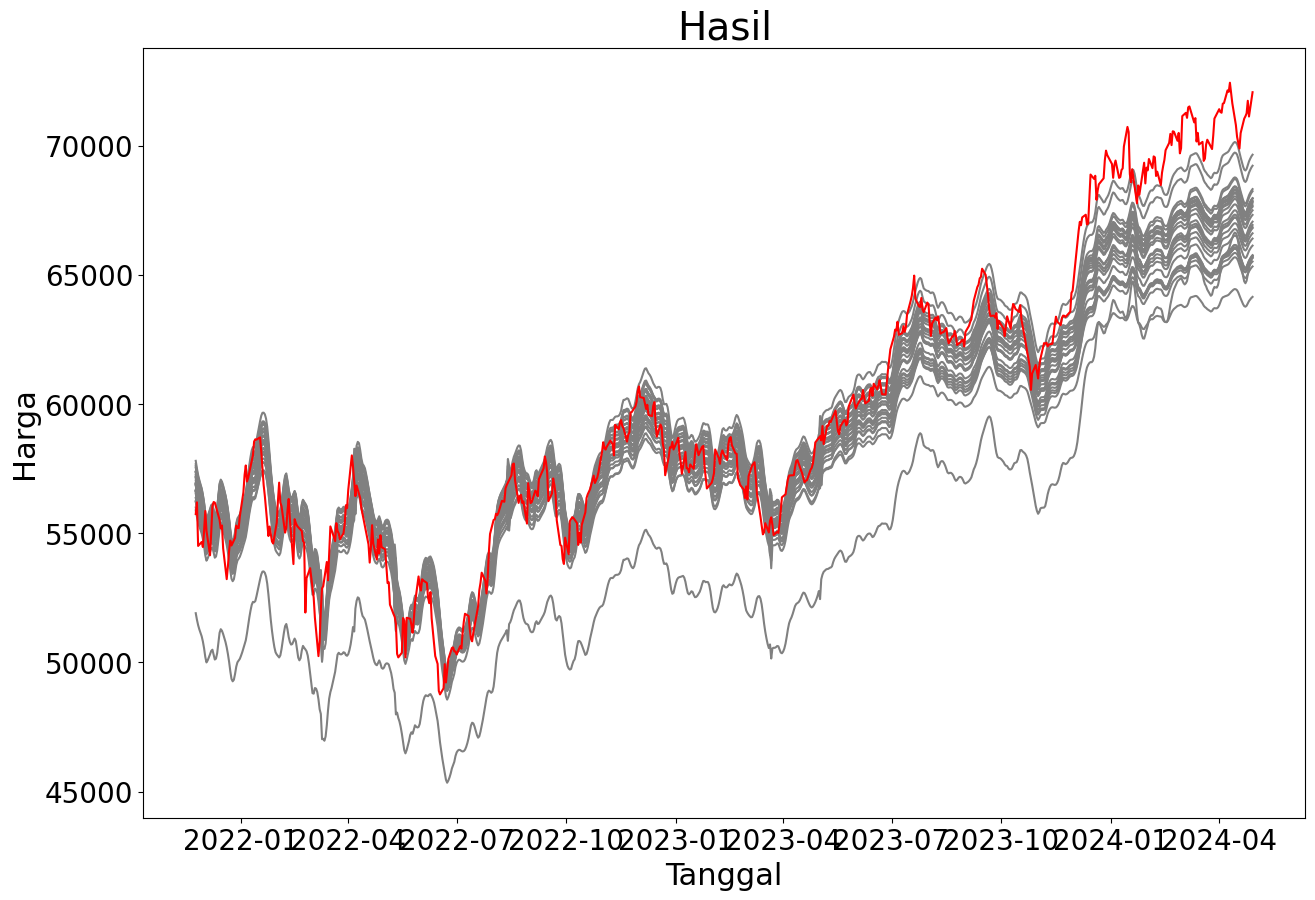

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

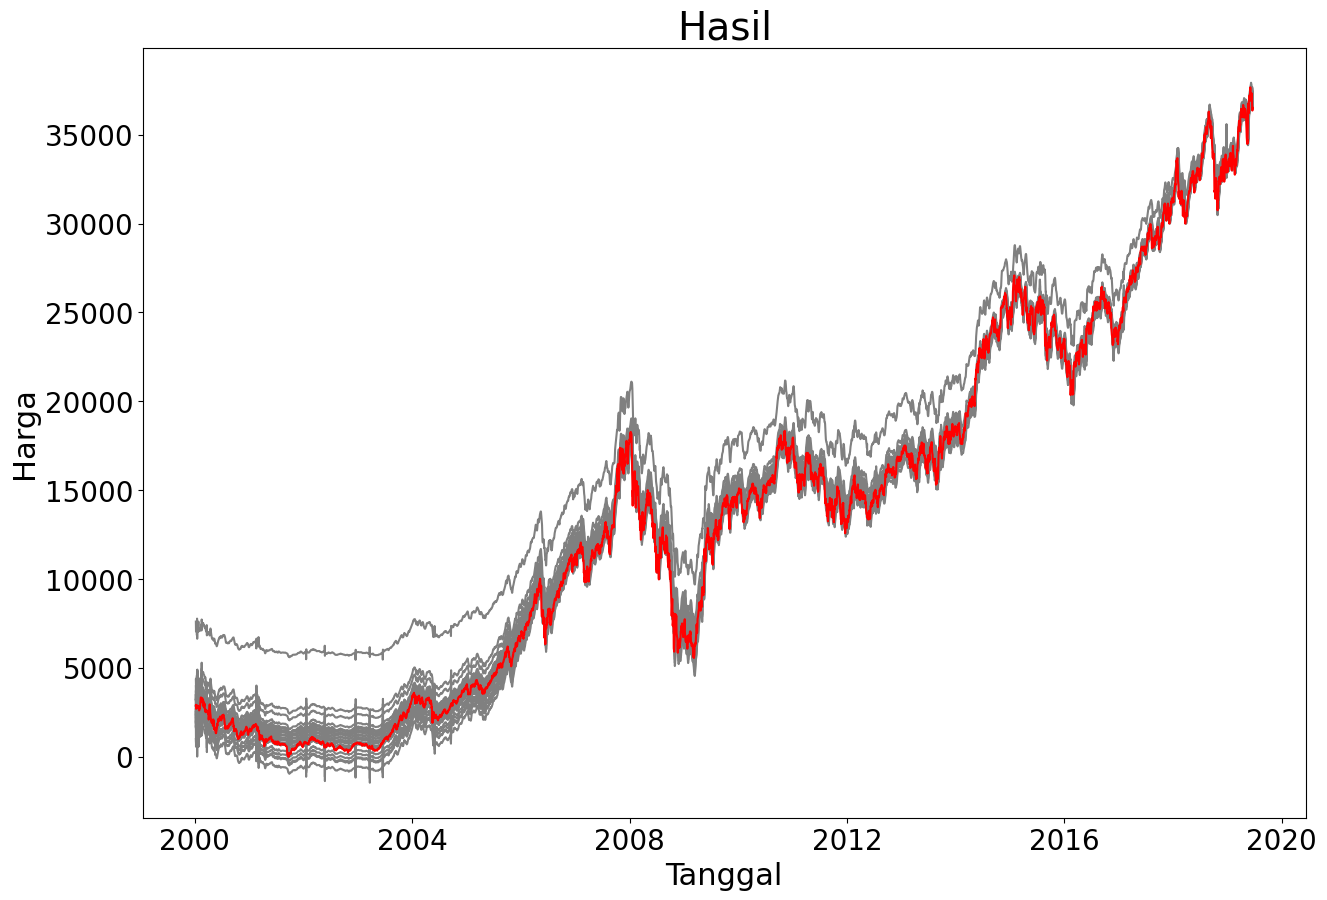

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## ANN dengan Bayesian

In [ ]:
ann = Sequential()
ann.add(Flatten(input_shape=(2,2)))
ann.add(Dense(64, activation='sigmoid'))
ann.add(Dropout(0.2))
ann.add(Dense(1, activation='linear'))

ann.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

ann.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 385 (1.50 KB)

 Trainable params: 385 (1.50 KB)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("annbo_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(ann)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"annbo_weights/best_annbo_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")

best_history = bm_histories[best_iter]

plt.figure(figsize=(10, 5))
plt.plot(best_history['loss'], label='Train Loss', color='blue')
plt.plot(best_history['val_loss'], label='Validation Loss', color='orange')
plt.title(f'Loss per Epoch pada Iterasi ke-{best_iter+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.777808   0.780635   0.777033   0.778826   0.779457   0.783692   
2021-11-25   0.774637   0.777826   0.774131   0.775748   0.776540   0.780528   
2021-11-26   0.771940   0.775434   0.771660   0.773129   0.774055   0.777836   
2021-11-27   0.769871   0.773596   0.769760   0.771120   0.772147   0.775769   
2021-11-28   0.768145   0.772060   0.768175   0.769442   0.770550   0.774045   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.886076   0.874126   0.871385   0.883276   0.874138   0.889460   
2024-04-26   0.887291   0.875161   0.872380   0.884433   0.875123   0.890601   
2024-04-27   0.888162   0.875902   0.873088   0.885262   0.875827   0.891415   
2024-04-28   0.888933   0.876558   0.873716   0.885995   0.876448   0.892135   
2024-04-29   0.889500   0.877041   0.874177   0.886534   0.876905   0.892665   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_INDIA.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_INDIA.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_INDIA.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

#bm_prediction_df.to_csv('hasilprediksicnnbo_INDIA.csv')
#bm_train_predictions.to_csv('hasilprediksicnnbo_train_INDIA.csv')
#bm_val_predictions.to_csv('hasilprediksicnnbo_val_INDIA.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksiannbo_INDIA.csv')
bm_train_predictions.to_csv('hasilprediksiannbo_train_INDIA.csv')
bm_val_predictions.to_csv('hasilprediksiannbo_val_INDIA.csv')


In [ ]:
!zip -r annbo_weights.zip /content/annbo_weights
from google.colab import files
files.download("annbo_weights.zip")

  adding: content/annbo_weights/ (stored 0%)
  adding: content/annbo_weights/best_annbo_weights_iter_14.weights.h5 (deflated 78%)
  adding: content/annbo_weights/best_annbo_weights_iter_2.weights.h5 (deflated 78%)
  adding: content/annbo_weights/best_annbo_weights_iter_23.weights.h5 (deflated 78%)
  adding: content/annbo_weights/best_annbo_weights_iter_17.weights.h5 (deflated 78%)
  adding: content/annbo_weights/best_annbo_weights_iter_11.weights.h5 (deflated 78%)
  adding: content/annbo_weights/best_annbo_weights_iter_9.weights.h5 (deflated 78%)
  adding: content/annbo_weights/best_annbo_weights_iter_25.weights.h5 (deflated 78%)
  adding: content/annbo_weights/best_annbo_weights_iter_13.weights.h5 (deflated 78%)
  adding: content/annbo_weights/best_annbo_weights_iter_20.weights.h5 (deflated 78%)
  adding: content/annbo_weights/best_annbo_weights_iter_16.weights.h5 (deflated 78%)
  adding: content/annbo_weights/best_annbo_weights_iter_5.weights.h5 (deflated 78%)
  adding: content/annbo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

489.88874955688925 380271.49543101067 616.6615728509526 466820713850726.06
685.9961120788759 904099.9129539073 950.8416865882076 0.018145222385559587
2090.8293926250503 8689545.973441126 2947.803584610265 0.03268882925888685


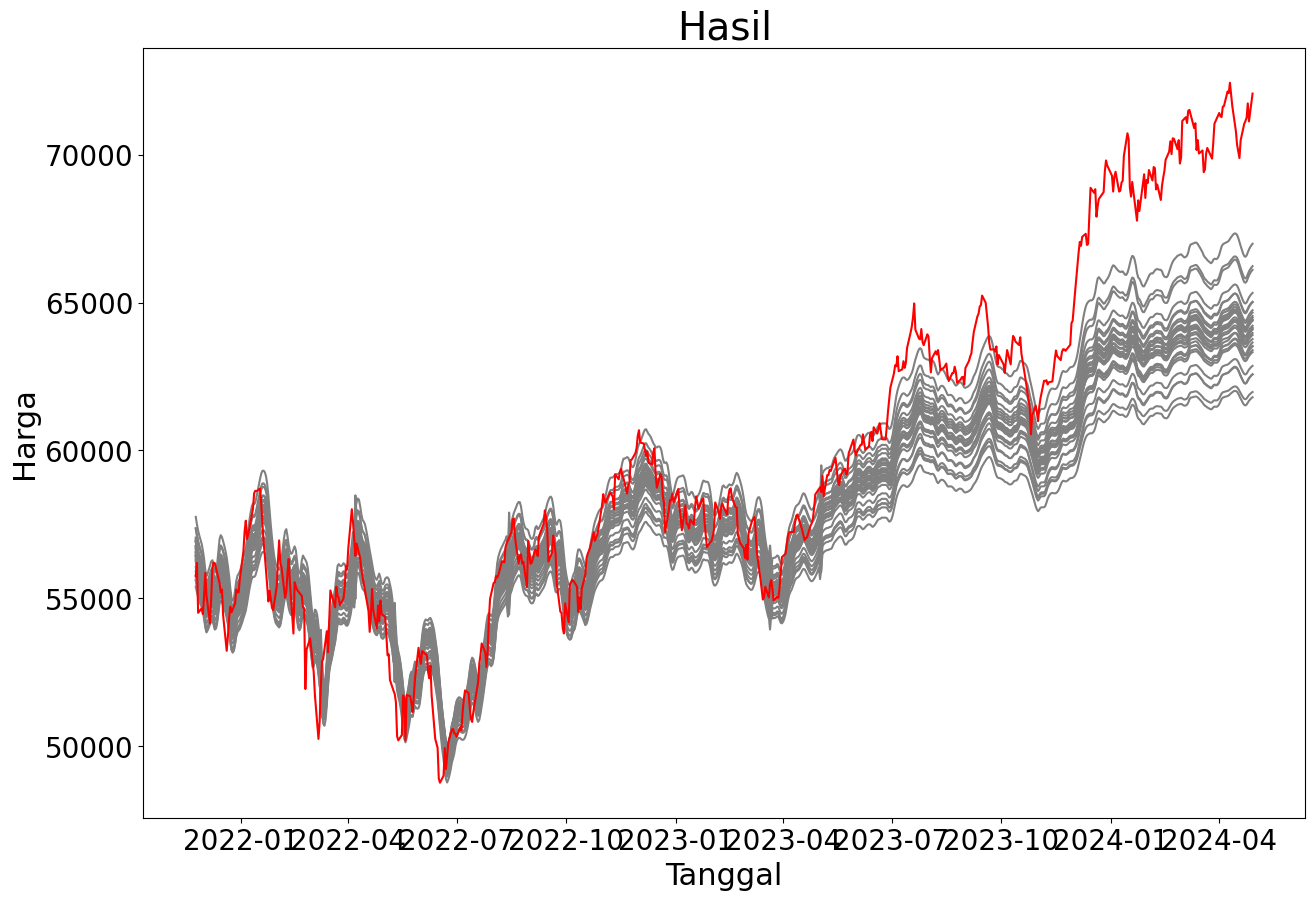

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

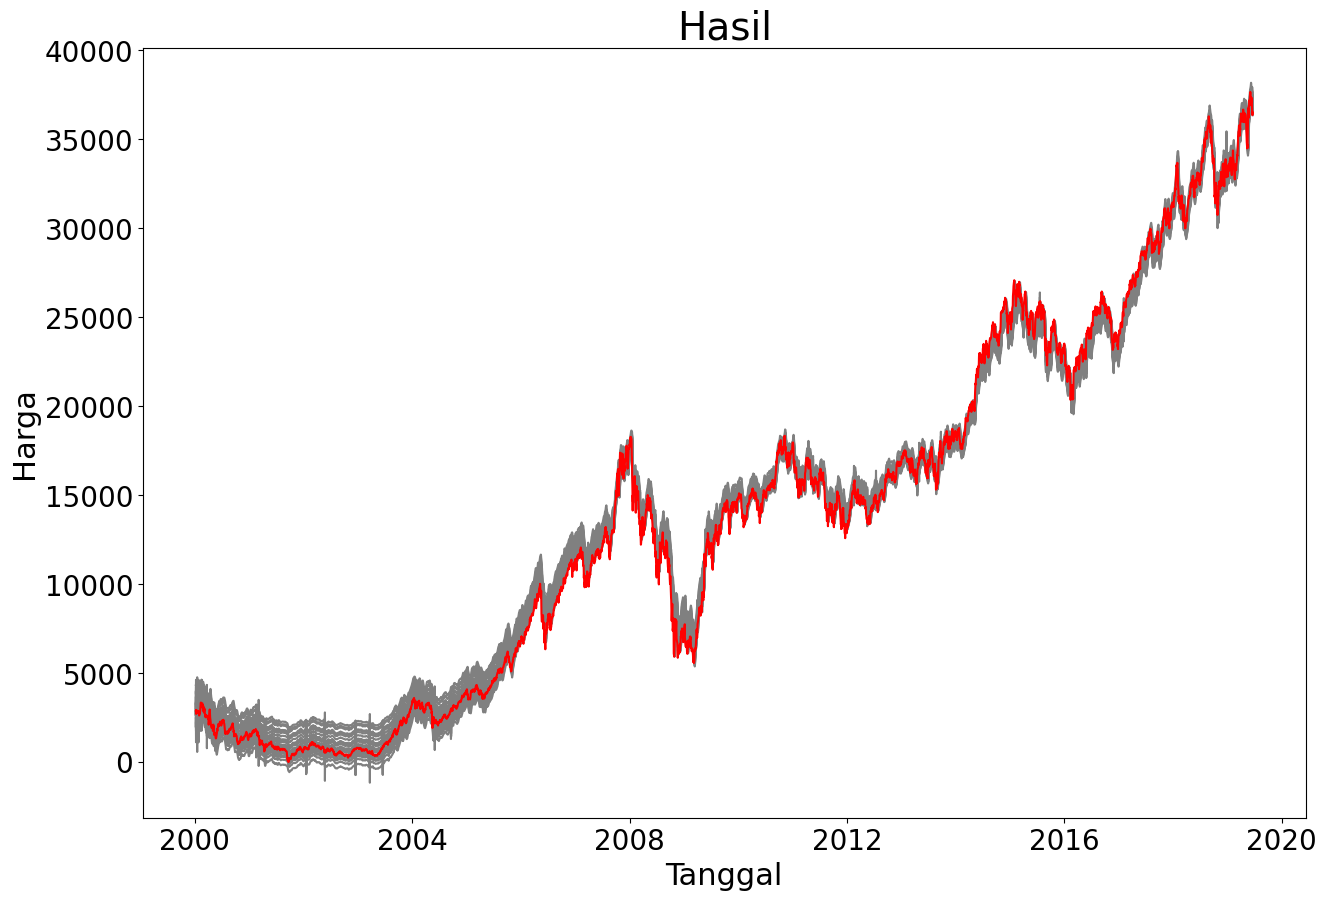

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## RNN

In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import SimpleRNN
def build_rnn_model(hp):
    model = Sequential()
    model.add(SimpleRNN(
        units=hp.Choice('rnn_units', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
        input_shape=(2, 2),
        return_sequences=False
    ))

    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))

    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

tuner = kt.RandomSearch(
    build_rnn_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    directory='random_search_rnn',
    project_name='rnn_tuning'
)

tuner.search(
    X_pred_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_pred_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Hyperparameters:
- RNN Units: {best_hps.get('rnn_units')}
- Activation: {best_hps.get('activation')}
- Dropout: {best_hps.get('dropout')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

Trial 60 Complete [00h 00m 35s]
val_loss: 0.00047606826410628855

Best val_loss So Far: 0.00016667658928781748
Total elapsed time: 01h 07m 27s

Best Hyperparameters:
- RNN Units: 8
- Activation: sigmoid
- Dropout: 0.1
- Learning Rate: 0.001



In [ ]:
def build_rnn_model(hp):
    model = Sequential()
    model.add(SimpleRNN(
        units=hp.Choice('rnn_units', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
        input_shape=(2, 2),
        return_sequences=False
    ))

    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))

    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model

bayesian_opt_tuner = kt.BayesianOptimization(
    build_rnn_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    overwrite=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

bayesian_opt_tuner.search(
    X_pred_train, y_train,
    epochs=150,
    validation_data=(X_pred_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)
best_rnn_models = bayesian_opt_tuner.get_best_models(num_models=1)
model = best_rnn_models[0]

print("\n--- Best Model Summary ---")
model.summary()

best_trial = bayesian_opt_tuner.oracle.get_best_trials(num_trials=1)[0]
best_hyperparameters = best_trial.hyperparameters.values
print("\nBest Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

Trial 60 Complete [00h 01m 29s]
val_loss: 0.000175351626239717

Best val_loss So Far: 0.00016333506209775805
Total elapsed time: 01h 03m 22s

--- Best Model Summary ---


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,153 (4.50 KB)

 Trainable params: 1,153 (4.50 KB)

 Non-trainable params: 0 (0.00 B)


Best Hyperparameters:
rnn_units: 32
activation: sigmoid
dropout: 0.2
learning_rate: 0.01


In [ ]:
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Conv1D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
rnn = Sequential()
rnn.add(SimpleRNN(8, activation='sigmoid', input_shape=(2, 2), return_sequences=False))
rnn.add(Dropout(0.1))
rnn.add(Dense(1))

rnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

rnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("rnnrs_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(rnn)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"rnnrs_weights/best_rnnrs_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")

best_history = bm_histories[best_iter]

plt.figure(figsize=(10, 5))
plt.plot(best_history['loss'], label='Train Loss', color='blue')
plt.plot(best_history['val_loss'], label='Validation Loss', color='orange')
plt.title(f'Loss per Epoch pada Iterasi ke-{best_iter+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.736768   0.743826   0.756606   0.748689   0.721097   0.696011   
2021-11-25   0.733994   0.741163   0.753670   0.745564   0.718102   0.693906   
2021-11-26   0.731620   0.738878   0.751150   0.742882   0.715576   0.692090   
2021-11-27   0.729878   0.737208   0.749314   0.740972   0.713644   0.690794   
2021-11-28   0.728315   0.735697   0.747644   0.739179   0.712046   0.689573   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.845782   0.847512   0.871805   0.890869   0.849560   0.781493   
2024-04-26   0.846977   0.848599   0.873023   0.892563   0.851435   0.782383   
2024-04-27   0.847979   0.849548   0.874086   0.894132   0.852840   0.783199   
2024-04-28   0.848800   0.850310   0.874941   0.895368   0.854067   0.783841   
2024-04-29   0.849402   0.850869   0.875567   0.896274   0.854973   0.784310   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_INDIA.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_INDIA.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_INDIA.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

#bm_prediction_df.to_csv('hasilprediksicnnbo_INDIA.csv')
#bm_train_predictions.to_csv('hasilprediksicnnbo_train_INDIA.csv')
#bm_val_predictions.to_csv('hasilprediksicnnbo_val_INDIA.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksirnnrs_INDIA.csv')
bm_train_predictions.to_csv('hasilprediksirnnrs_train_INDIA.csv')
bm_val_predictions.to_csv('hasilprediksirnnrs_val_INDIA.csv')


In [ ]:
!zip -r rnnrs_weights.zip /content/rnnrs_weights
from google.colab import files
files.download("rnnrs_weights.zip")

  adding: content/rnnrs_weights/ (stored 0%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_24.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_15.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_7.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_20.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_21.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_23.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_25.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_16.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_6.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_28.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_18.weights.h5 (deflated 89%)
  adding: content/rnnr

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

1096.437967699001 1718015.1949757105 1310.73078661322 1577185800182800.2
1488.8911569039778 3881090.053692073 1970.048236387138 0.03356445820662964
5315.603009748035 34412198.07558026 5866.191104590803 0.08623429560716324


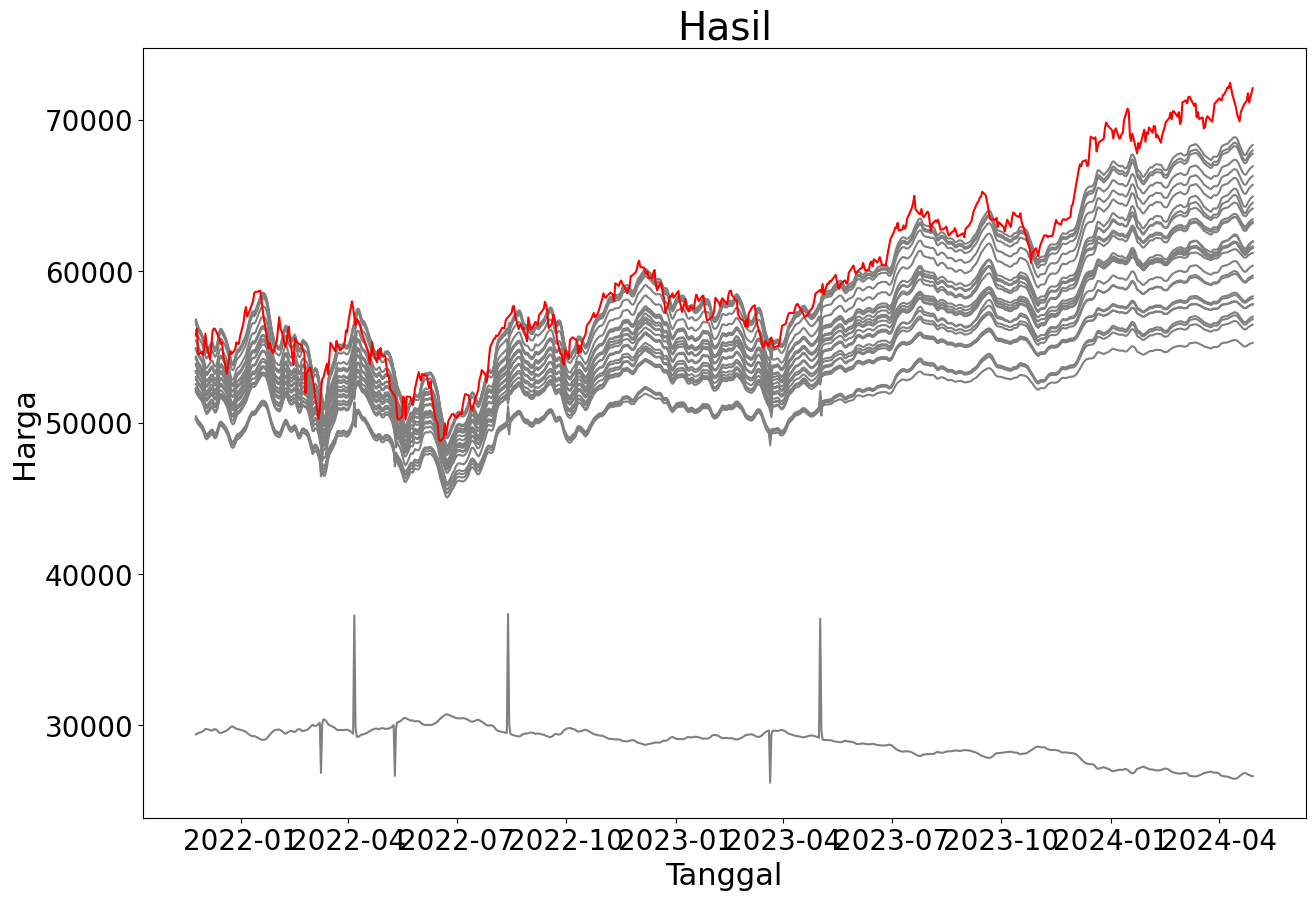

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

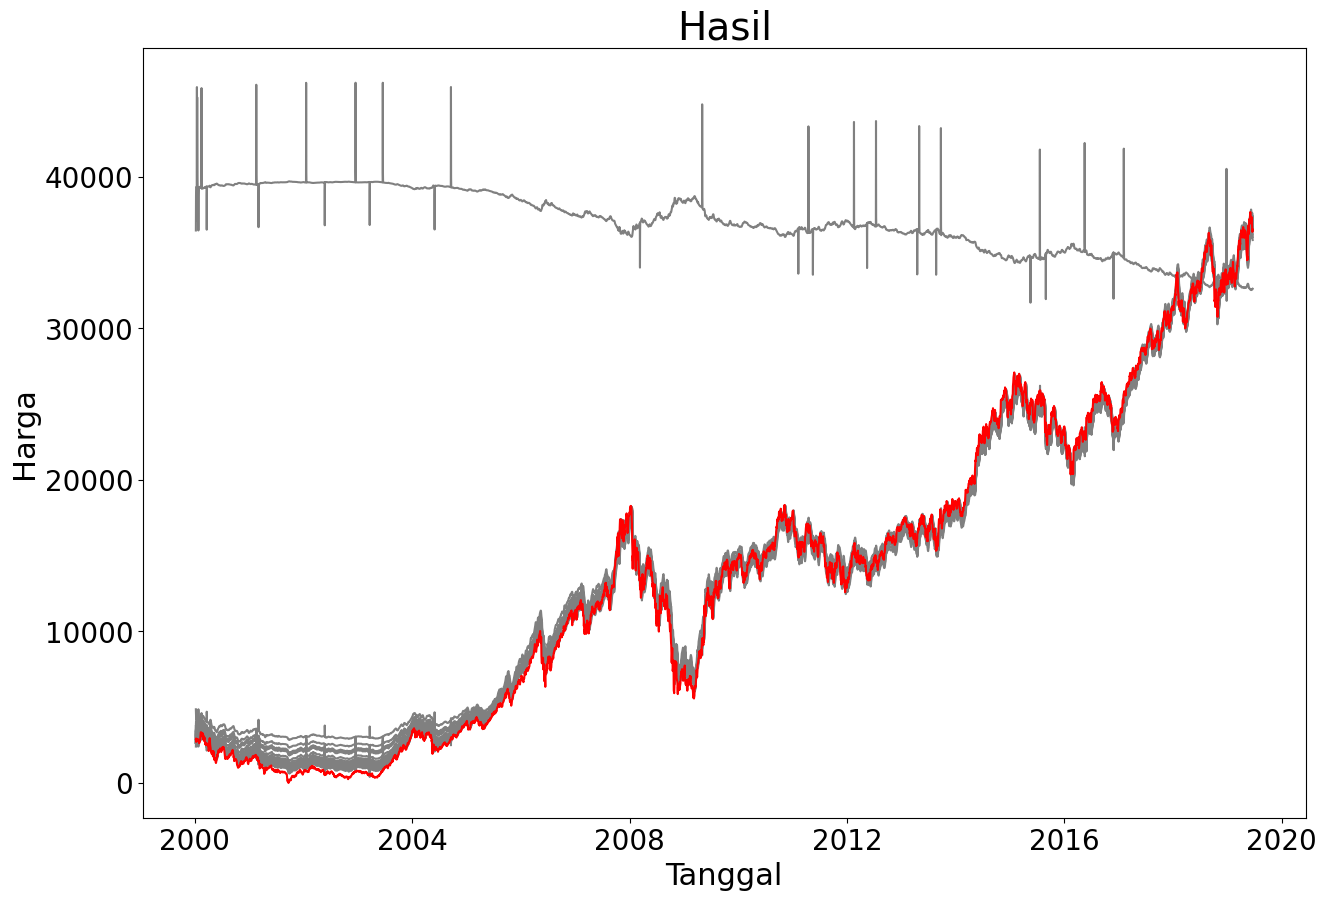

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## RNN dengan Bayesian

In [ ]:
from tensorflow.keras.layers import SimpleRNN
rnn = Sequential()
rnn.add(SimpleRNN(32, activation='sigmoid', input_shape=(2, 2), return_sequences=False))
rnn.add(Dropout(0.2))
rnn.add(Dense(1))

rnn.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

rnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 32)             │         1,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,153 (4.50 KB)

 Trainable params: 1,153 (4.50 KB)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("rnnbo_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(rnn)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"rnnbo_weights/best_rnnbo_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")

best_history = bm_histories[best_iter]

plt.figure(figsize=(10, 5))
plt.plot(best_history['loss'], label='Train Loss', color='blue')
plt.plot(best_history['val_loss'], label='Validation Loss', color='orange')
plt.title(f'Loss per Epoch pada Iterasi ke-{best_iter+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.794845   0.780210   0.790366   0.775637   0.793793   0.778703   
2021-11-25   0.790377   0.776527   0.785884   0.771713   0.789815   0.774904   
2021-11-26   0.786619   0.773391   0.782122   0.768387   0.786445   0.771690   
2021-11-27   0.783778   0.771109   0.779245   0.765943   0.783925   0.769285   
2021-11-28   0.781404   0.769056   0.776891   0.763790   0.781761   0.767225   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   1.019407   0.954746   1.009998   0.973798   0.974746   0.956283   
2024-04-26   1.023081   0.957205   1.013546   0.976724   0.977307   0.958846   
2024-04-27   1.025995   0.959276   1.016307   0.979236   0.979387   0.960954   
2024-04-28   1.028483   0.960988   1.018683   0.981296   0.981134   0.962715   
2024-04-29   1.030321   0.962250   1.020438   0.982814   0.982422   0.964013   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_INDIA.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_INDIA.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_INDIA.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

#bm_prediction_df.to_csv('hasilprediksicnnbo_INDIA.csv')
#bm_train_predictions.to_csv('hasilprediksicnnbo_train_INDIA.csv')
#bm_val_predictions.to_csv('hasilprediksicnnbo_val_INDIA.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksirnnbo_INDIA.csv')
bm_train_predictions.to_csv('hasilprediksirnnbo_train_INDIA.csv')
bm_val_predictions.to_csv('hasilprediksirnnbo_val_INDIA.csv')


In [ ]:
!zip -r rnnbo_weights.zip /content/rnnbo_weights
from google.colab import files
files.download("rnnbo_weights.zip")

  adding: content/rnnbo_weights/ (stored 0%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_2.weights.h5 (deflated 60%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_19.weights.h5 (deflated 60%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_12.weights.h5 (deflated 60%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_17.weights.h5 (deflated 60%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_26.weights.h5 (deflated 60%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_16.weights.h5 (deflated 60%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_4.weights.h5 (deflated 60%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_14.weights.h5 (deflated 60%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_24.weights.h5 (deflated 60%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_18.weights.h5 (deflated 60%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_25.weights.h5 (deflated 60%)
  adding: content/rnnb

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

485.5549602233893 335983.70347029355 579.6410125847666 666841571688752.6
675.1791596283794 885264.8843398875 940.8851600168256 0.017780132170584117
830.1920932162609 1108731.6221655067 1052.9632577471575 0.01413403307445892


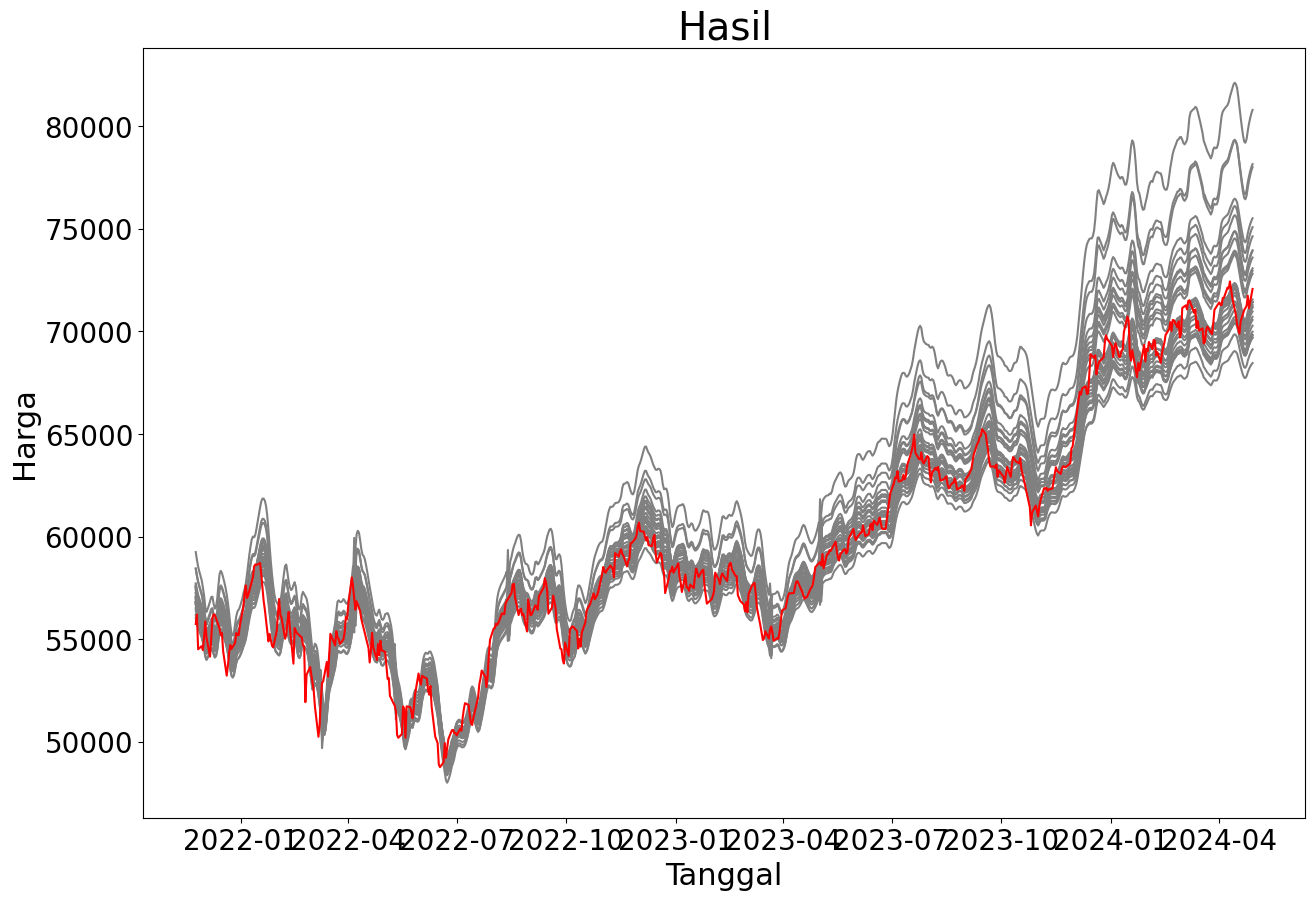

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

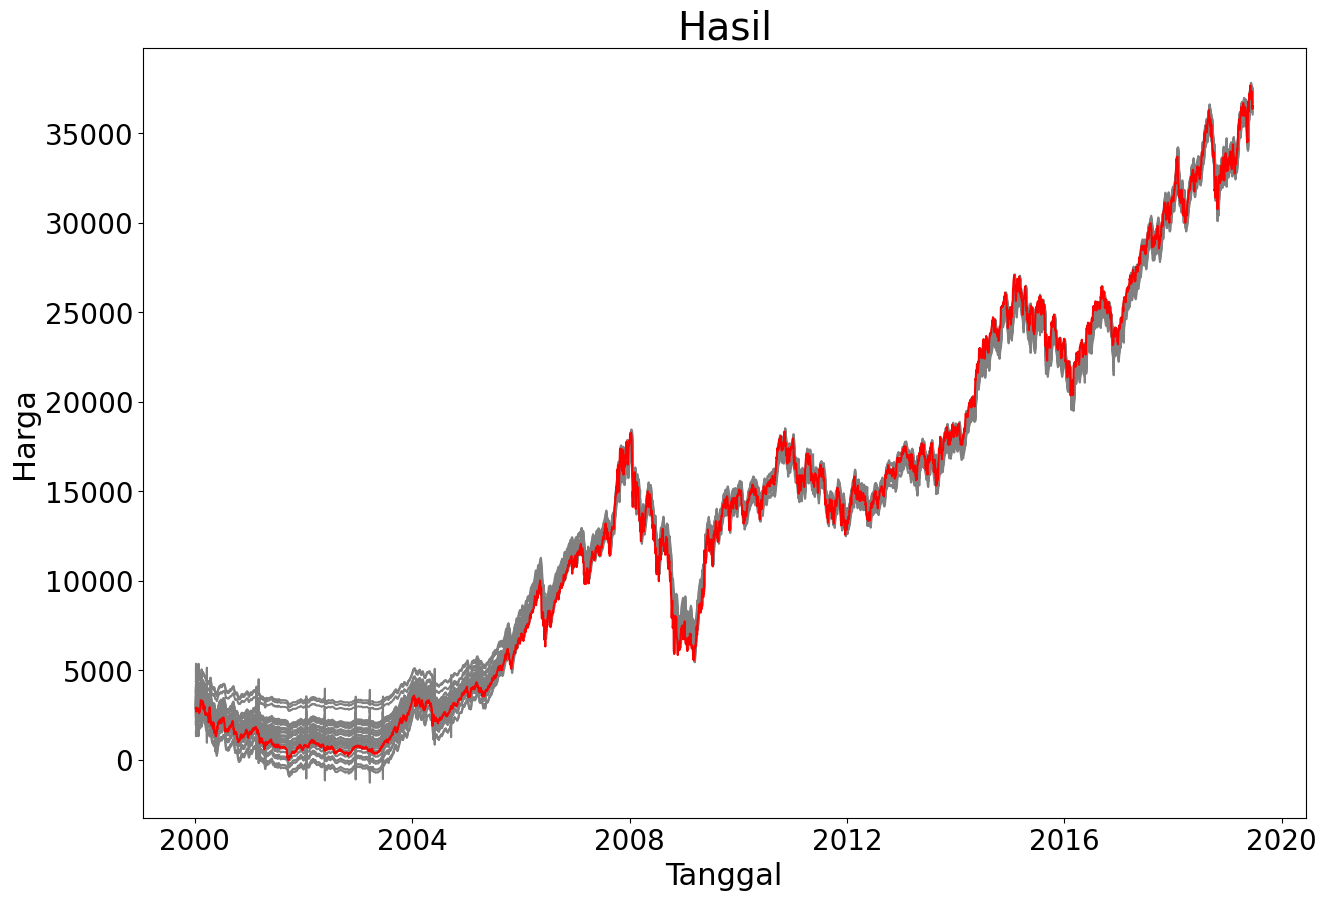

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## LSTM dengan Input Harga Saham dan Keputusan Jual Beli

In [ ]:
datacopy = data_full[3:]
datacopy

In [ ]:
datacopy['EMA_50'] = datacopy['Close'].ewm(span=50, adjust=False).mean()
datacopy['EMA_200'] = datacopy['Close'].ewm(span=200, adjust=False).mean()
datacopy['Diff']= datacopy['EMA_50']-datacopy['EMA_200']
datacopy['sign'] = datacopy['Diff'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
datacopy['sign_change'] = datacopy['sign'].diff().apply(lambda x: 1 if x != 0 else 0)
filter = datacopy[datacopy['sign_change'] == 1]
idx_datafull = filter.index
datacopy['label'] = np.where(
    (datacopy['sign'] == 1) & (datacopy['sign_change'] != 0), 'Sell',
    np.where((datacopy['sign'] == -1) & (datacopy['sign_change'] != 0), 'Buy', 'Keep')
)
check = datacopy[datacopy['sign_change'] != 0]
check

In [ ]:
datacopy['label1'] = datacopy['label'].apply(lambda x: -1 if x == 'Sell' else (1 if x == 'Buy' else 0))
datacopy
check = datacopy[datacopy['label1'] != 0]
check

In [ ]:
#data_full['Close'] = pd.to_numeric(datacopy['Close'])
#datacopy['label1'] = pd.to_numeric(datacopy['label1'])

X_actual, y_actual, dates_actual = windowed_df_close(datacopy[['Close','label1']],2)
banyakn = len(X_actual)
Mq_80 = int(banyakn * .8)
Mq_90 = int(banyakn * .9)
dates_actual_train, X_actual_train, y_actual_train = dates_actual[:Mq_80], X_actual[:Mq_80], y_actual[:Mq_80]
dates_actual_val, X_actual_val, y_actual_val = dates_actual[Mq_80:Mq_90], X_actual[Mq_80:Mq_90], y_actual[Mq_80:Mq_90]
dates_actual_test, X_actual_test, y_actual_test = dates_actual[Mq_90:], X_actual[Mq_90:], y_actual[Mq_90:]

In [ ]:
datacopy

In [ ]:
y_actual.shape

In [ ]:
from hyperopt import hp

space = {
    'hiddenLayerOne': hp.choice('hiddenLayerOne', [32, 64, 128]),
    'hiddenLayerTwo': hp.choice('hiddenLayerTwo', [32, 64, 128]),
    'activation': hp.choice('activation', ['tanh', 'relu']),
    'epochs': hp.choice('epochs',[50,100,150,200]),
    'learning_rate': hp.choice('learning_rate', [0.0001, 0.001, 0.01]),
    'dropout': hp.choice('dropout', [0.1, 0.2, 0.3]),
    'batch_size': hp.choice('batch_size', [32, 64, 128])
}

def objective(params):
    model = Sequential([
        LSTM(params['hiddenLayerOne'], activation=params['activation'], return_sequences=True, input_shape=(2, 2)),
        Dropout(params['dropout']),
        LSTM(params['hiddenLayerTwo'], activation=params['activation']),
        Dropout(params['dropout']),
        Dense(1, activation='linear')
    ])

    model.compile(optimizer=Adam(learning_rate=params['learning_rate']),
                  loss='mse',
                  metrics=['mean_absolute_error'])

    es = EarlyStopping(monitor='val_loss',mode='min',
                       verbose=1,patience=5)

    model.fit(X_actual_train, y_actual_train, batch_size=int(params['batch_size']),validation_data=(X_actual_val, y_actual_val))

    score, acc = model.evaluate(X_actual_val, y_actual_val, verbose=0)

    return {'loss': -acc,
            'status': STATUS_OK,
            'model': model,
            'params': params}

In [ ]:
from hyperopt import hp, fmin, tpe, Trials, space_eval, STATUS_OK
from hyperopt import hp, fmin, tpe, Trials, space_eval, STATUS_OK
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
trials = Trials()

In [ ]:
best_params = fmin(
  fn=objective,
  space=space,
  algo=tpe.suggest,
  max_evals=175,
  trials=trials)

In [ ]:
space_eval(space, best_params)

In [ ]:
LSTM_EMA_model = Sequential([
    layers.LSTM(32, activation = 'relu', return_sequences = True, input_shape = (2,2)),
    layers.Dropout(0.2),
    layers.LSTM(32,activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation = 'linear')
])

LSTM_EMA_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

LSTM_EMA_model.summary()

RUN

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta = 0.0001,
    restore_best_weights=True
)

In [ ]:
result = []
mapes = []
prediction_result = []
histories = []

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(LSTM_EMA_model)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss = 'mse',
        metrics = ['mean_absolute_error'],
    )

    history = model.fit(X_actual_train, y_actual_train, batch_size=128, validation_data=(X_actual_val, y_actual_val), epochs=50)

    result.append(history)
    histories.append(history.history)

    predictions = model.predict(X_actual_test).flatten()
    mape = mean_absolute_percentage_error(y_actual_test, predictions)
    prediction_result.append(predictions)
    mapes.append(mape)
    print(f"Iteration {i+1}: MAPE = {mape}")

In [ ]:
import numpy as np

all_train_loss = np.array([h['loss'] for h in histories])
all_val_loss = np.array([h['val_loss'] for h in histories])

mean_train_loss = np.mean(all_train_loss, axis=0)
mean_val_loss = np.mean(all_val_loss, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(mean_train_loss, label='Rata-rata Training Loss')
plt.plot(mean_val_loss, label='Rata-rata Validation Loss')
plt.title('Rata-rata Loss per Epoch dari 30 Iterasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
prediction_df = pd.DataFrame(prediction_result).transpose()
prediction_df.index = dates_actual_test
prediction_df.columns = [f'Iterasi {i+1}' for i in range(prediction_df.shape[1])]
print(prediction_df)

In [ ]:
prediction_df2 = prediction_df.copy(deep=True)
print(prediction_df2)

In [ ]:
prediction_df2 = prediction_df2.multiply(range_value)
print(prediction_df2)

In [ ]:
y_test2 = y_actual_test * range_value
y_test2

In [ ]:
prediction_df2['Rata2'] = prediction_df2.mean(axis=1)
print(prediction_df2)

In [ ]:
from math import sqrt
hasil = prediction_df2['Rata2']
close_test_mae = mean_absolute_error(y_test2, hasil)
close_test_mse = mean_squared_error(y_test2, hasil)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test2, hasil)
close_test_mae, close_test_mse, close_test_rmse, close_test_mape

In [ ]:
prediction_df2.to_csv('hasilprediksilstm2fit_INDIA.csv')